<a href="https://colab.research.google.com/github/PedroChumpitaz/Modern-Survival-Modeling/blob/main/Miner%C3%ADa_Datos_Supervivencia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Librerias

In [ ]:
pip install lifelines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.2/349.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 6.5 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=427f35bf7d697abe9a44537b638d206d7da9d84f9fa3b957ed6ee2b0413ce318
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, WeibullFitter, ExponentialFitter
from lifelines.plotting import add_at_risk_counts
from lifelines import KaplanMeierFitter, WeibullFitter
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

##### Entendimiento de datos

###### P612C

In [ ]:
def leer_datos(year):
    file_path = f'/content/drive/MyDrive/Bases de datos/Enaho01-{year}.csv'
    return pd.read_csv(file_path, encoding='latin1')

# Concatenar datos de 2008 a 2019
df_2008_2019 = pd.concat((leer_datos(year) for year in range(2008, 2020)), ignore_index=True)

df_enaho = df_2008_2019.copy()

# Filtrar por P612N == 2
df_2008_2019 = df_2008_2019[df_2008_2019['P612N'] == 2]

# Convertir columnas especificadas a numérico, incluida P612C
columns_to_convert = ['P612A', 'P612B', 'P612C', 'P612G', 'P612H', 'D612G', 'D612H', 'I612G', 'I612H', 'P612C1', 'TICUEST01']
for column in columns_to_convert:
    df_2008_2019[column] = pd.to_numeric(df_2008_2019[column], errors='coerce')

# Seleccionar columnas cualitativas excluyendo las especificadas más la columna P612C
columns_qualitative = [col for col in df_2008_2019.columns if col not in columns_to_convert] + ['P612C']
df_subset = df_2008_2019[columns_qualitative]

# Eliminación de valores famosos en el subset, incluyendo cuidadosamente P612C
valores_famosos_especificos = [99, 999, 9999, 99999, 999999, 999999.99, 9]
for valor in valores_famosos_especificos:
    df_subset = df_subset.replace(valor, np.nan)

# Filtrar el DataFrame para excluir registros donde P612C es null
df_subset = df_subset.dropna(subset=['P612C'])
all_data = df_subset

<ipython-input-10-036727a2bb17>:3: DtypeWarning: Columns (10,11,12,14,15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path, encoding='latin1')
<ipython-input-10-036727a2bb17>:3: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path, encoding='latin1')


In [ ]:
all_data['TVIDA'] = all_data['AÑO'] - all_data['P612C']

all_data['censored'] = 1  # Esto marca todos los registros como censurados
all_data = all_data[all_data['TVIDA'] > 0]

###### ENAHO

In [ ]:
# Filtrado de datos basado en condiciones específicas
df_enaho = df_enaho[(df_enaho['P612'] != 9) & (df_enaho['P612A'] != 99) &
                    (df_enaho['P612B'] != 9) & (df_enaho['P612C'] != 9999) &
                    (df_enaho['P612G'] != 999999)]


# Conversión de ciertas columnas a numérico y manejo de valores especiales
df_enaho['P612A'] = pd.to_numeric(df_enaho['P612A'], errors='coerce')
df_enaho['P612G'] = pd.to_numeric(df_enaho['P612G'], errors='coerce')
df_enaho['P612A'].replace(99, np.nan, inplace=True)
df_enaho['P612G'].replace(999999, np.nan, inplace=True)
df_enaho['P612H'].replace(999999, np.nan, inplace=True)


# Creación de la columna TVIDA
df_enaho['P612C'] = pd.to_numeric(df_enaho['P612C'], errors='coerce')
df_enaho['TVIDA'] = df_enaho['AÑO'] - df_enaho['P612C']

# Filtrar para asegurar que TVIDA sea mayor a 0
df_enaho = df_enaho[df_enaho['TVIDA'] > 0]

##### No parametrico - Kaplan

In [ ]:
data = all_data[all_data['AÑO']==2019]

<ipython-input-13-98aa7e38acd2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['censored'] = 1


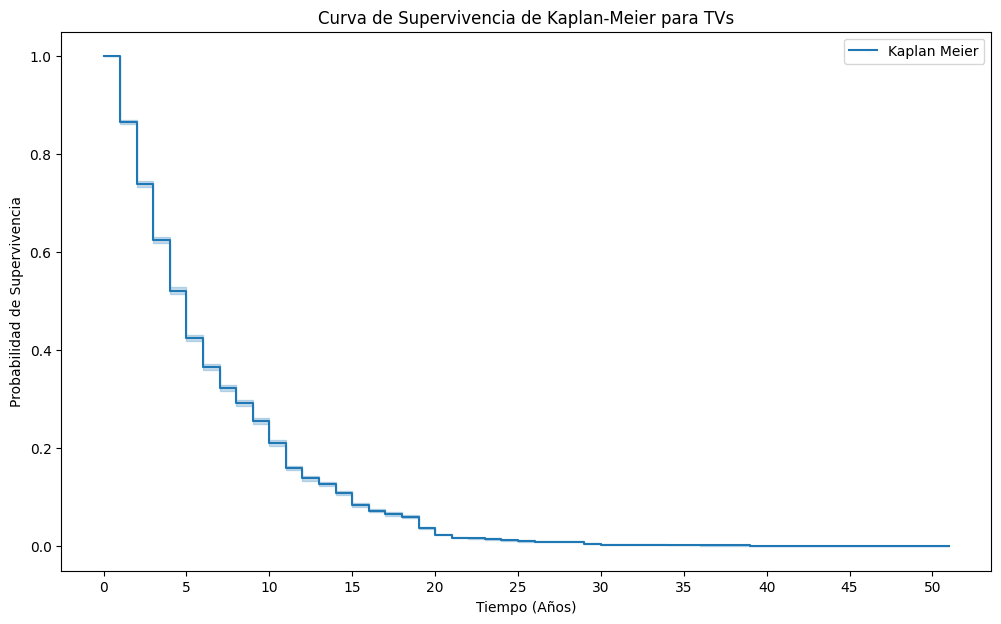

In [ ]:
data['censored'] = 1

# Inicialización y ajuste del estimador de Kaplan-Meier
kmf = KaplanMeierFitter()
kmf.fit(data['TVIDA'], event_observed=data['censored'], label='Kaplan Meier')

# Visualización de la curva de supervivencia de Kaplan-Meier
plt.figure(figsize=(12, 7))
kmf.plot_survival_function()
plt.title('Curva de Supervivencia de Kaplan-Meier para TVs')
plt.xlabel('Tiempo (Años)')
plt.ylabel('Probabilidad de Supervivencia')

# Ajustando los marcadores en el eje X para que aparezcan cada 5 unidades
max_time = data['TVIDA'].max()  # Obtiene el máximo valor de tiempo
ticks = np.arange(0, max_time+1, 5)  # Crea una lista de ticks desde 0 hasta el máximo tiempo, con pasos de 5
plt.xticks(ticks)  # Establece los ticks personalizados en el eje X

plt.show()

In [ ]:
# Obteniendo los tiempos y las probabilidades de supervivencia de la curva de Kaplan-Meier
kmf_times = kmf.survival_function_.index
kmf_probabilities = kmf.survival_function_['Kaplan Meier']
mean_survival_time_km = np.sum(np.diff(kmf_times) * kmf_probabilities.iloc[:-1])

# Estimación de la mediana de supervivencia con Kaplan-Meier
median_survival_time = kmf.median_survival_time_

print(f"Media: La vida útil promedio de los televisores es de aproximadamente {mean_survival_time_km:.2f} años.")
print("Mediana de Supervivencia:", median_survival_time)

Media: La vida útil promedio de los televisores es de aproximadamente 6.63 años.
Mediana de Supervivencia: 5.0


In [ ]:
# Puntos de tiempo específicos para los cuales se desea la probabilidad de supervivencia
time_points = [5, 10, 15]  # Años

# Obtener las probabilidades de supervivencia en los puntos de tiempo específicos
survival_probabilities_kmf = kmf.predict(time_points)

# Convertir las probabilidades a porcentajes y redondearlas
survival_percentages_kmf = np.round(survival_probabilities_kmf * 100, 1)

# Imprimir los resultados
print("Probabilidades de supervivencia (en %) en los años 5, 10, y 15:", survival_percentages_kmf)

Probabilidades de supervivencia (en %) en los años 5, 10, y 15: 5     42.5
10    21.1
15     8.4
Name: Kaplan Meier, dtype: float64


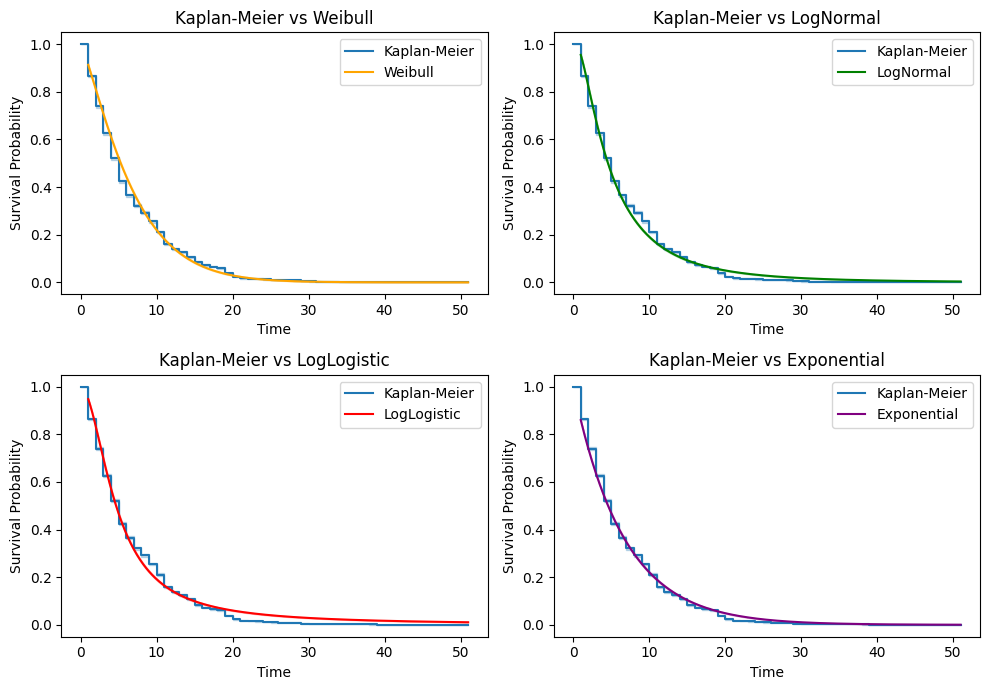

In [ ]:
from lifelines import KaplanMeierFitter, WeibullFitter, ExponentialFitter, LogNormalFitter, LogLogisticFitter
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame with 'TVIDA' and 'censored' columns
T = data['TVIDA']
E = data['censored']

# Instantiate the KaplanMeierFitter and fit the data
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E, label='Kaplan-Meier')

# Define the parametric models to compare
models = {
    'Weibull': WeibullFitter(),
    'LogNormal': LogNormalFitter(),
    'LogLogistic': LogLogisticFitter(),
    'Exponential': ExponentialFitter()
}

# Define colors for each model's plot
colors = {
    'Weibull': 'orange',
    'LogNormal': 'green',
    'LogLogistic': 'red',
    'Exponential': 'purple'
}

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.ravel()  # Flatten the array of axes

# Plot each model in a separate subplot
for ax, (name, model) in zip(axes, models.items()):
    kmf.plot_survival_function(ax=ax, ci_show=True)  # Plot Kaplan-Meier
    model.fit(T, event_observed=E, label=name)
    model.plot_survival_function(ax=ax, ci_show=True, color=colors[name])  # Plot the parametric model with specified color

    ax.set_title(f'Kaplan-Meier vs {name}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Survival Probability')
    ax.legend()

# Adjust the layout so that plots do not overlap
plt.tight_layout()
plt.show()

In [ ]:
from lifelines import WeibullFitter, ExponentialFitter, LogNormalFitter, LogLogisticFitter
from lifelines.plotting import qq_plot
import pandas as pd

best_model, best_log_likelihood = None, float('-inf')  # Initialize best_log_likelihood to negative infinity
for name, model in models.items():
    model.fit(T, event_observed=E)
    log_likelihood = model.log_likelihood_  # Get the log-likelihood of the fitted model
    print(f"Model: {name}, Log-likelihood: {log_likelihood}")
    if log_likelihood > best_log_likelihood:
        best_model, best_log_likelihood = name, log_likelihood

print(f"Best Model: {best_model}, Log-likelihood: {best_log_likelihood}")

Model: Weibull, Log-likelihood: -66203.26478921475
Model: LogNormal, Log-likelihood: -65538.20314277892
Model: LogLogistic, Log-likelihood: -66247.93115954762
Model: Exponential, Log-likelihood: -66952.14525059747
Best Model: LogNormal, Log-likelihood: -65538.20314277892


In [ ]:
from lifelines import WeibullFitter, ExponentialFitter, LogNormalFitter, LogLogisticFitter
from lifelines.plotting import qq_plot
import pandas as pd

best_model, best_aic = None, float('inf')
for name, model in models.items():
    model.fit(T, event_observed=E)
    aic = model.AIC_
    print(f"Model: {name}, AIC: {aic}")
    if aic < best_aic:
        best_model, best_aic = name, aic

print(f"Best Model: {best_model}, AIC: {best_aic}")

Model: Weibull, AIC: 132410.5295784295
Model: LogNormal, AIC: 131080.40628555784
Model: LogLogistic, AIC: 132499.86231909523
Model: Exponential, AIC: 133906.29050119495
Best Model: LogNormal, AIC: 131080.40628555784


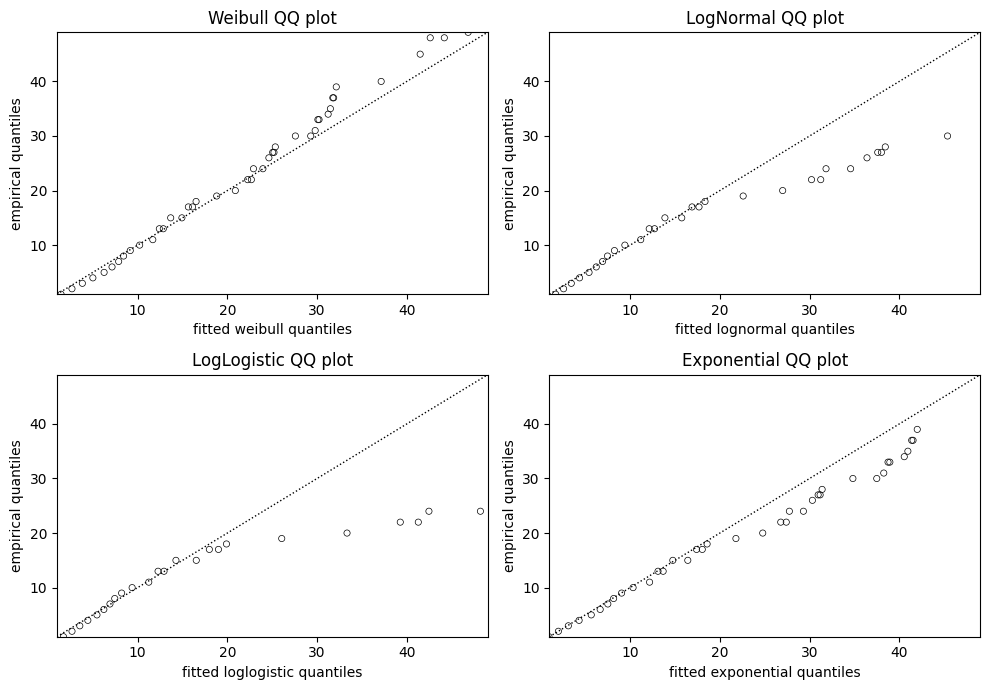

In [ ]:
import matplotlib.pyplot as plt
from lifelines import WeibullFitter, ExponentialFitter, LogNormalFitter, LogLogisticFitter
from lifelines.plotting import qq_plot

best_fit_model_name = "Weibull"  # Replace with the actual best fit model after you've run the analysis

# Create a 2x2 subplot for Q-Q plots
fig, axes = plt.subplots(2, 2, figsize=(10, 7))  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easier access

for i, (name, model) in enumerate(models.items()):
    model.fit(data['TVIDA'], data['censored'])  # Fit the model
    ax = axes[i]  # Select the subplot axis
    qq_plot(model, ax=ax)  # Generate Q-Q plot on the selected axis
    ax.set_title(f'{name} QQ plot')  # Set title for each subplot

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

##### Modelamiento Weibull

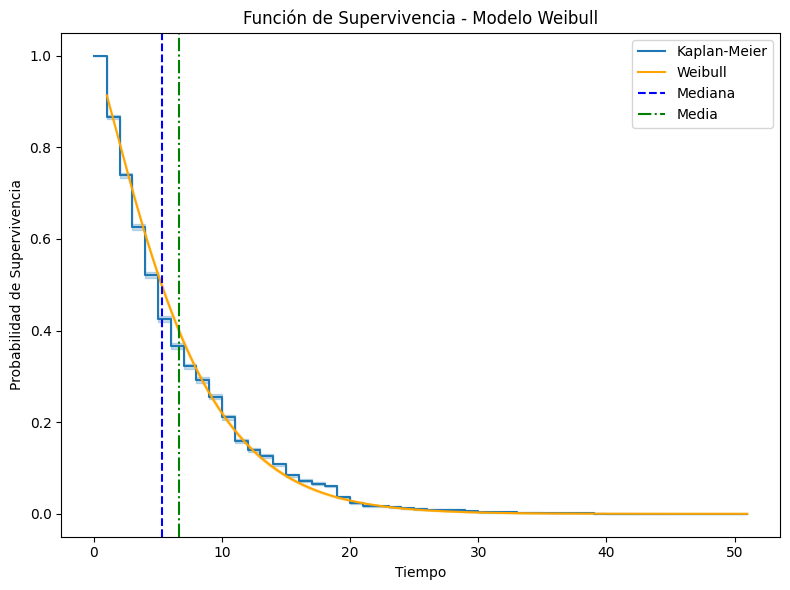

In [ ]:
from lifelines import WeibullFitter
import matplotlib.pyplot as plt
import numpy as np

# Asumiendo que 'data' es tu DataFrame con las columnas 'TVIDA' y 'censored'
T = data['TVIDA']
E = data['censored']

# Definir y ajustar el modelo de Weibull
weibull_model = WeibullFitter()
weibull_model.fit(T, event_observed=E, label='Weibull')

# Instantiate the KaplanMeierFitter and fit the data
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E, label='Kaplan-Meier')

# Calcular la mediana
mediana = weibull_model.median_survival_time_

# Para calcular la media, integramos la función de supervivencia hasta un tiempo máximo
# Este tiempo máximo debe ser seleccionado con cuidado, dependiendo de los datos
tiempo_maximo = T.max()  # Ejemplo, puede ajustarse según tus datos
tiempos = np.linspace(0, tiempo_maximo, 1000)
sf = weibull_model.survival_function_at_times(tiempos)
media = np.trapz(sf, tiempos)

# Crear una figura para la gráfica
plt.figure(figsize=(8, 6))
ax = plt.subplot(111)

# Graficar la función de supervivencia del modelo de Weibull
kmf.plot_survival_function(ax=ax, ci_show=True)  # Plot Kaplan-Meier
weibull_model.plot_survival_function(ax=ax, ci_show=True, color='orange')

# Añadir líneas para media y mediana
ax.axvline(x=mediana, color='blue', linestyle='--', label='Mediana')
ax.axvline(x=media, color='green', linestyle='-.', label='Media')

# Configurar el título y etiquetas del eje
ax.set_title('Función de Supervivencia - Modelo Weibull')
ax.set_xlabel('Tiempo')
ax.set_ylabel('Probabilidad de Supervivencia')

# Mostrar la leyenda
ax.legend()

# Ajustar el diseño y mostrar la gráfica
plt.tight_layout()
plt.show()

In [ ]:
from lifelines import WeibullFitter
import numpy as np

# Asumiendo que 'data' es tu DataFrame con las columnas 'TVIDA' y 'censored'
T = data['TVIDA']
E = data['censored']

# Definir y ajustar el modelo de Weibull
weibull_model = WeibullFitter()
weibull_model.fit(T, event_observed=E)

# Calcular la mediana de vida útil
mediana_vida_util = weibull_model.median_survival_time_

# Calcular la vida útil promedio (media) hasta un tiempo máximo
tiempo_maximo = T.max()  # Ajustar según tus datos
tiempos = np.linspace(0, tiempo_maximo, 1000)
sf = weibull_model.survival_function_at_times(tiempos)
vida_util_promedio = np.trapz(sf, tiempos)

# Calcular las probabilidades de supervivencia a 5, 10 y 15 años
prob_supervivencia_5 = weibull_model.predict(5)
prob_supervivencia_10 = weibull_model.predict(10)
prob_supervivencia_15 = weibull_model.predict(15)

# Convertir a porcentajes
prob_supervivencia_5 *= 100
prob_supervivencia_10 *= 100
prob_supervivencia_15 *= 100

# Imprimir los resultados
print(f"Vida Útil Promedio (años): {vida_util_promedio:.2f}")
print(f"Mediana de Vida Útil (años): {mediana_vida_util:.2f}")
print(f"Probabilidad de Supervivencia a 5 Años (%): {prob_supervivencia_5:.2f}")
print(f"Probabilidad de Supervivencia a 10 Años (%): {prob_supervivencia_10:.2f}")
print(f"Probabilidad de Supervivencia a 15 Años (%): {prob_supervivencia_15:.2f}")


Vida Útil Promedio (años): 6.66
Mediana de Vida Útil (años): 5.28
Probabilidad de Supervivencia a 5 Años (%): 52.27
Probabilidad de Supervivencia a 10 Años (%): 21.95
Probabilidad de Supervivencia a 15 Años (%): 8.28


##### 2008 vs 2019

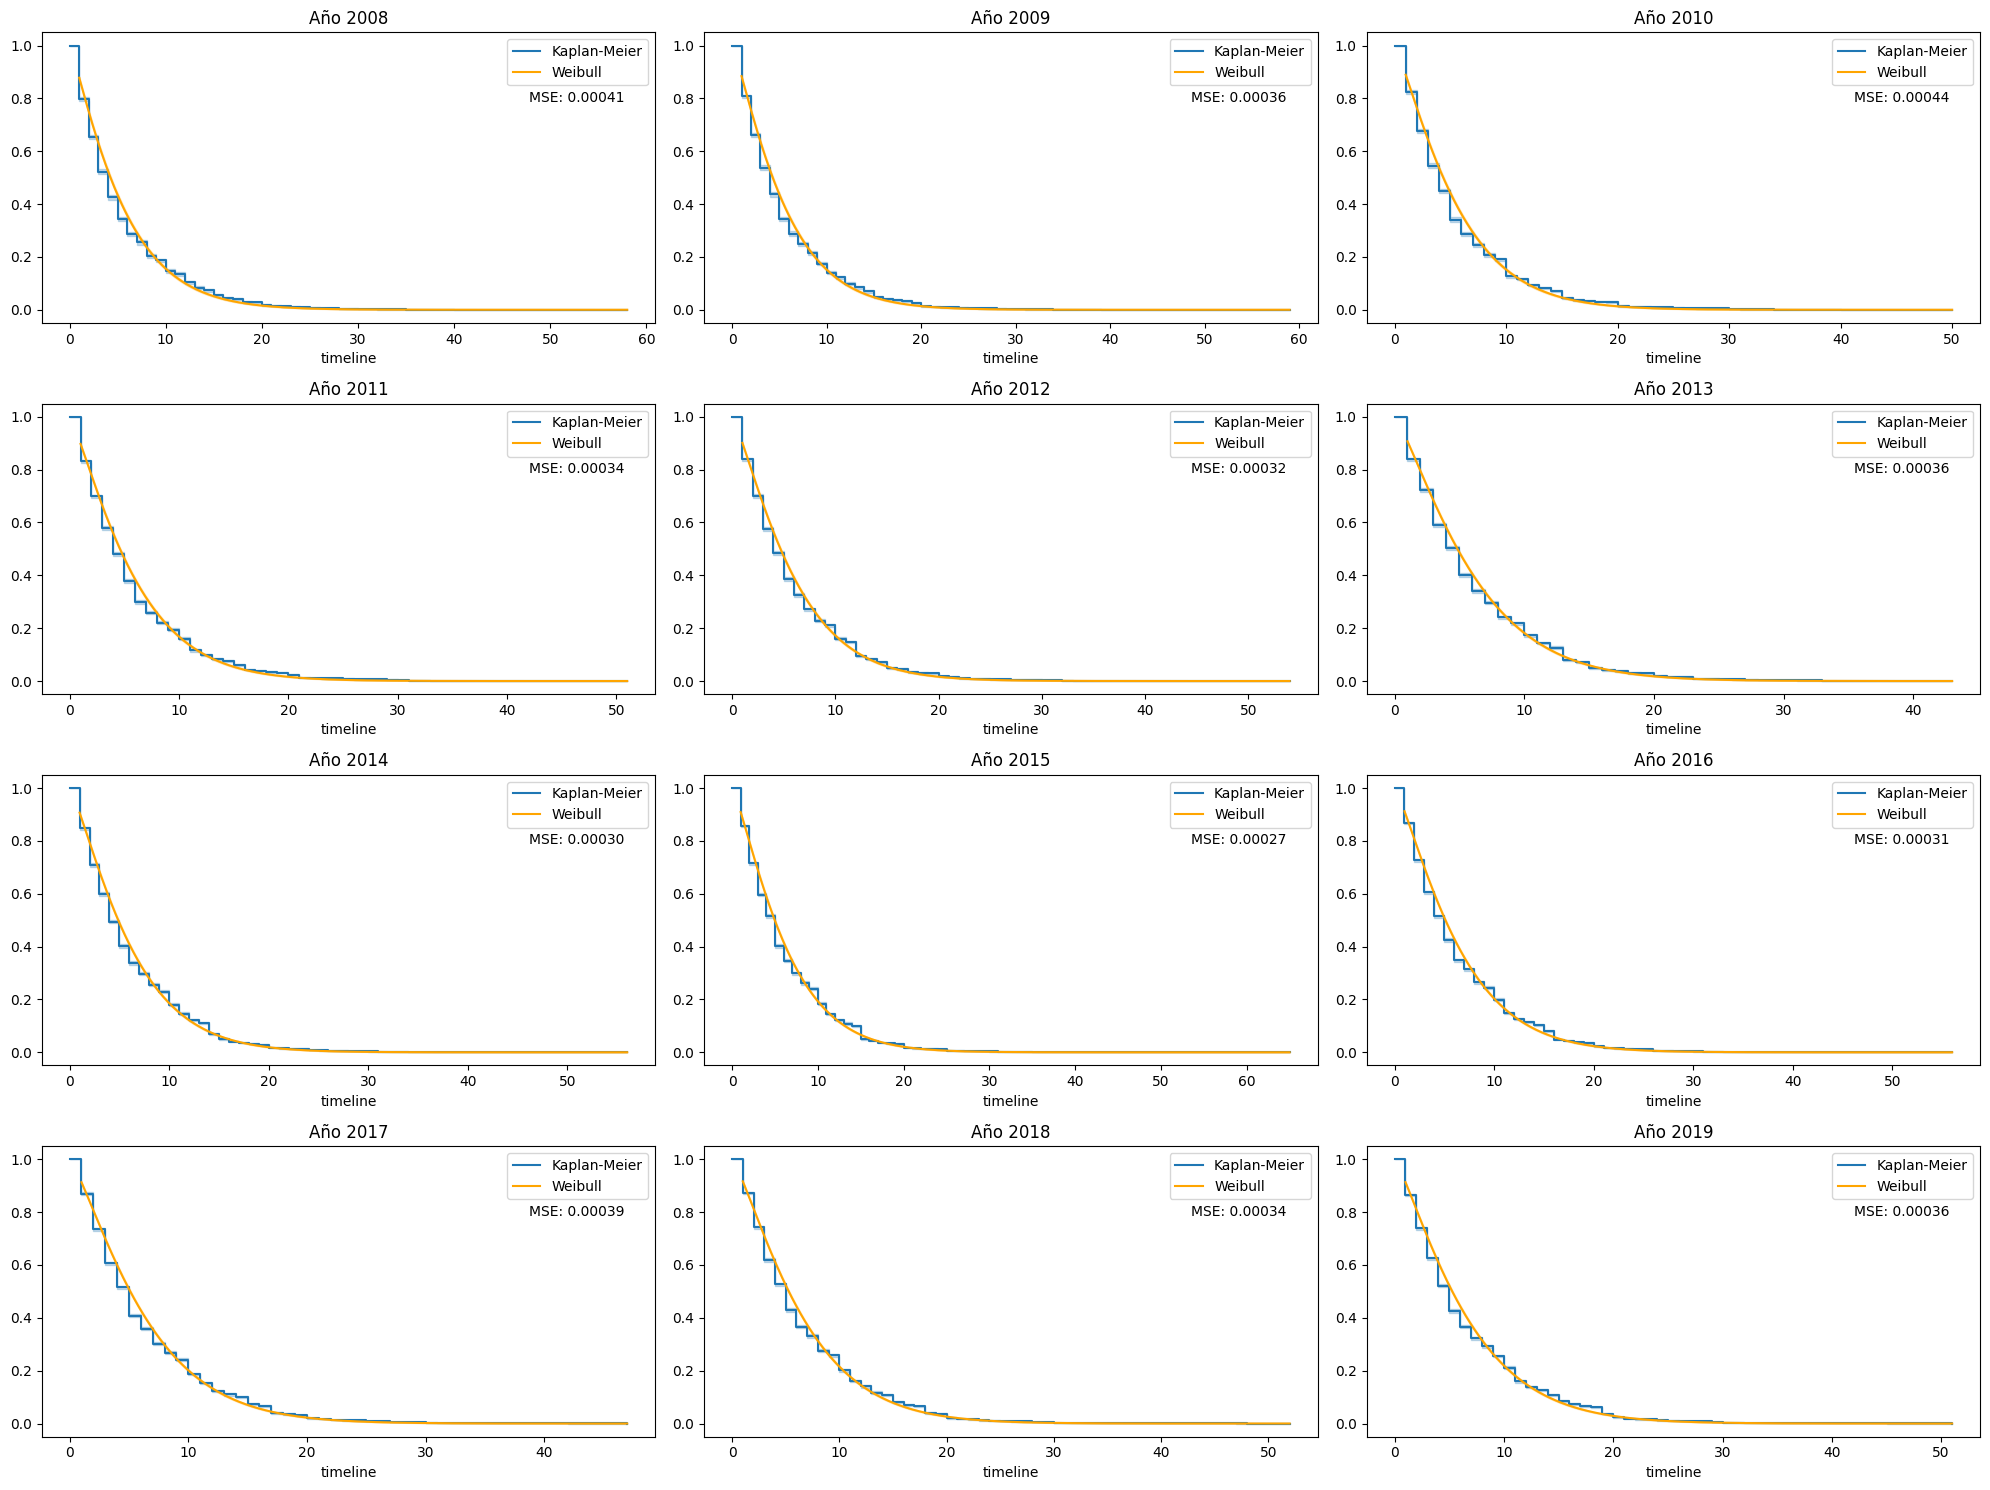

In [ ]:
from lifelines import WeibullFitter, KaplanMeierFitter
import matplotlib.pyplot as plt
import numpy as np

# Crear la figura para la matriz de gráficos
plt.figure(figsize=(20, 15))

# Bucle para cada año en all_data
for year in range(2008, 2020):
    # Filtrar datos por año
    data_by_year = all_data[all_data['AÑO'] == year]

    # Asumimos que 'TVIDA' y 'censored' ya están correctamente calculados y asignados en all_data
    T = data_by_year['TVIDA']
    E = data_by_year['censored']

    # Ajustar los modelos de Weibull y Kaplan-Meier
    weibull_model = WeibullFitter()
    weibull_model.fit(T, event_observed=E, label='Weibull')

    kmf = KaplanMeierFitter()
    kmf.fit(T, event_observed=E, label='Kaplan-Meier')

    # Calcular el tiempo máximo, tiempos para función de supervivencia, y MSE
    tiempo_maximo = T.max()
    tiempos = np.linspace(0, tiempo_maximo, 1000)
    sf_weibull = weibull_model.survival_function_at_times(tiempos)
    sf_kmf = kmf.survival_function_at_times(tiempos)
    mse = np.mean((sf_kmf - sf_weibull)**2)

    # Seleccionar el subgráfico correspondiente
    ax = plt.subplot(4, 3, year - 2007)  # Ajuste para una matriz de 4x3
    kmf.plot_survival_function(ax=ax, ci_show=True)
    weibull_model.plot_survival_function(ax=ax, ci_show=True, color='orange')
    ax.set_title(f'Año {year}')
    ax.legend()

    # Mostrar el MSE en el gráfico
    ax.text(0.95, 0.75, f'MSE: {mse:.5f}', transform=ax.transAxes, fontsize=10, verticalalignment='bottom', horizontalalignment='right')

# Ajustar el diseño y mostrar los gráficos
plt.tight_layout()
plt.show()

In [ ]:
all_data

,AÑO,MES,CONGLOME,VIVIENDA,HOGAR,UBIGEO,DOMINIO,ESTRATO,P612N,P612,FACTOR07,NCONGLOME,P612C,TVIDA,censored
1,2008,4.0,1.0,10.0,11,10101,4,4,2,1.0,181.310000,NaN,2000.0,8.0,1
27,2008,4.0,1.0,19.0,11,10101,4,4,2,1.0,181.310000,NaN,1999.0,9.0,1
53,2008,4.0,1.0,27.0,11,10101,4,4,2,1.0,181.310000,NaN,2002.0,6.0,1
79,2008,4.0,1.0,35.0,11,10101,4,4,2,1.0,181.310000,NaN,2004.0,4.0,1
105,2008,4.0,1.0,54.0,11,10101,4,4,2,1.0,181.310000,NaN,2002.0,6.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9113755,2019,12.0,11349.0,55.0,11,180211,6,8,2,1.0,81.656929,43822.0,2005.0,14.0,1
9113781,2019,12.0,11350.0,3.0,11,180101,3,3,2,1.0,80.257660,43948.0,2016.0,3.0,1
9113807,2019,12.0,11350.0,22.0,11,180101,3,3,2,1.0,80.257660,43948.0,2015.0,4.0,1
9113859,2019,12.0,11350.0,78.0,11,180101,3,3,2,1.0,80.257660,43948.0,2016.0,3.0,1


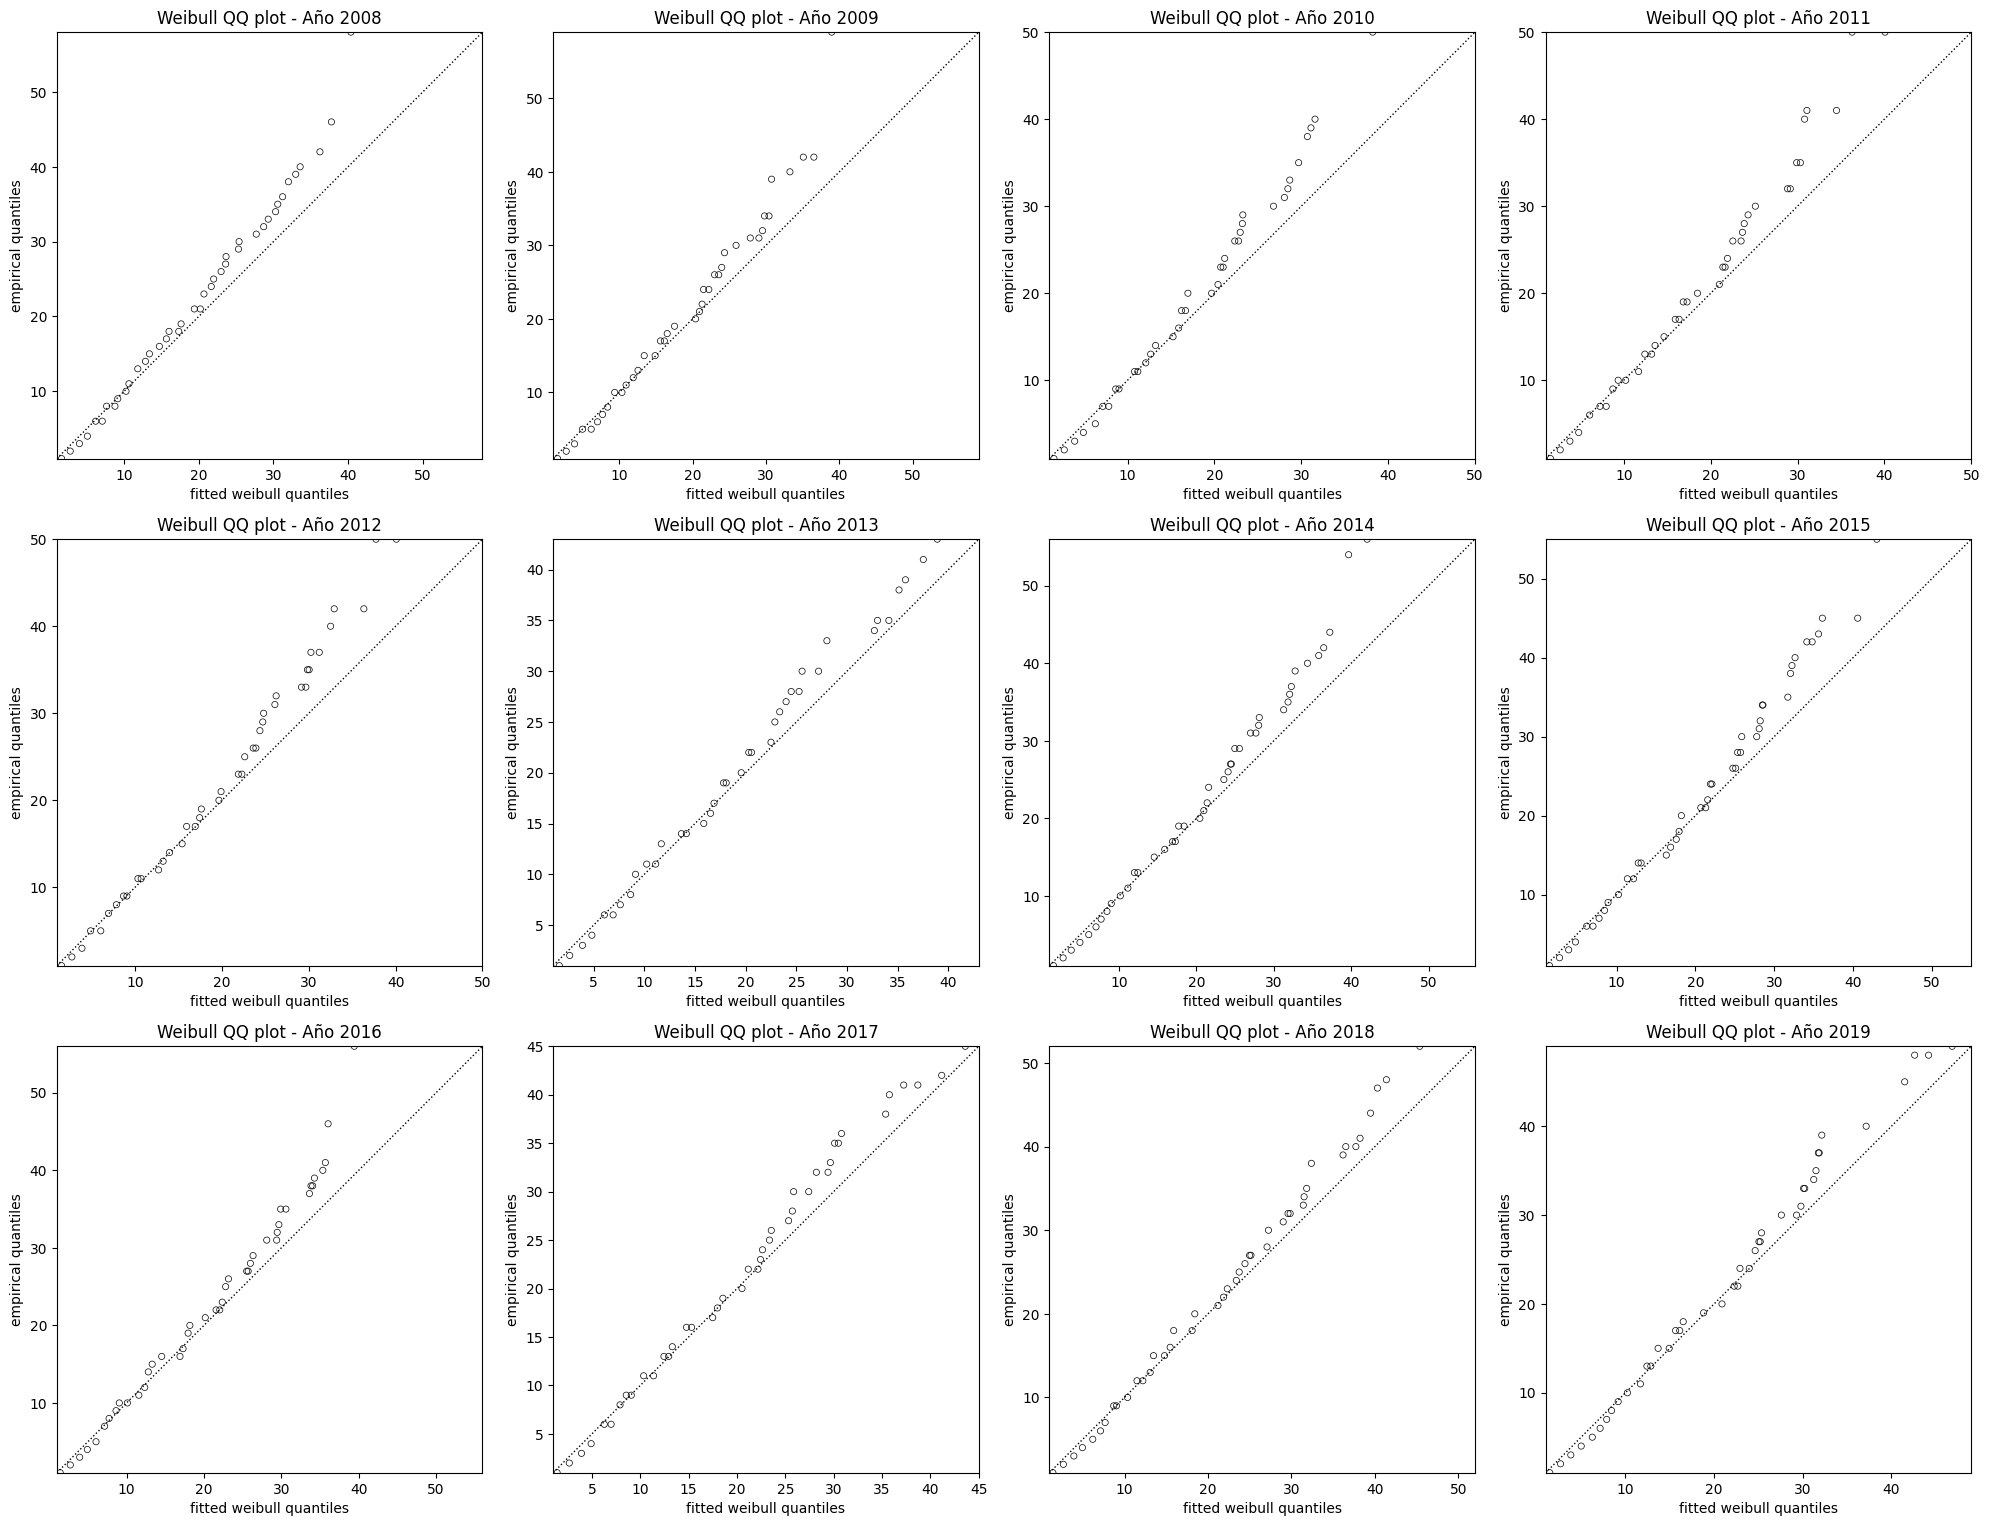

In [ ]:
import matplotlib.pyplot as plt
from lifelines import WeibullFitter
from lifelines.plotting import qq_plot
import pandas as pd

# Asumiendo que all_data ya está limpio y preparado
plt.figure(figsize=(20, 20))

for i, year in enumerate(range(2008, 2020)):
    data_by_year = all_data[(all_data['AÑO'] == year) & ~all_data['TVIDA'].isna()]

    if not data_by_year.empty:
        T = data_by_year['TVIDA']
        E = data_by_year['censored']

        weibull_model = WeibullFitter()
        weibull_model.fit(T, E)

        ax = plt.subplot(4, 4, i + 1)
        qq_plot(weibull_model, ax=ax)
        ax.set_title(f'Weibull QQ plot - Año {year}')
    else:
        print(f"No hay datos para el año {year}")

plt.tight_layout()
plt.show()


In [ ]:
from lifelines import WeibullFitter
from scipy.special import gamma
import pandas as pd
import numpy as np

# Diccionario para almacenar los resultados
resultados = {}

# Bucle para procesar cada año desde 2008 hasta 2019
for year in range(2008, 2020):
    # Filtrar los datos de cada año
    data_by_year = all_data[all_data['AÑO'] == year]

    # Asegurarse de que existen datos para procesar
    if not data_by_year.empty:
        # Ajuste del modelo de Weibull
        wf = WeibullFitter()
        wf.fit(durations=data_by_year['TVIDA'], event_observed=data_by_year['censored'])

        # Extracción de los parámetros del modelo de Weibull
        lambda_ = wf.lambda_
        rho_ = wf.rho_

        # Calcular la mediana de vida útil y la vida útil promedio
        mediana_vida_util = wf.median_survival_time_
        tiempo_maximo = data_by_year['TVIDA'].max()
        tiempos = np.linspace(0, tiempo_maximo, 1000)
        sf = wf.survival_function_at_times(tiempos)
        vida_util_promedio = np.trapz(sf, tiempos)
        variance_weibull = lambda_**2 * gamma(1 + 2 / rho_) - (gamma(1 + 1 / rho_))**2
        std_dev_weibull = np.sqrt(variance_weibull)

        # Calcular las probabilidades de supervivencia a 5, 10 y 15 años
        prob_supervivencia_5 = wf.predict(5) * 100
        prob_supervivencia_10 = wf.predict(10) * 100
        prob_supervivencia_15 = wf.predict(15) * 100

        # Almacenar los resultados en el diccionario
        resultados[year] = {
            'Cantidad de Registros': data_by_year.shape[0],
            'Vida Útil Promedio': vida_util_promedio,
            'Mediana de Vida Útil': mediana_vida_util,
            'Varianza': variance_weibull,
            'Desviación Estandar': std_dev_weibull,
            'Probabilidad de Supervivencia a 5 Años': prob_supervivencia_5,
            'Probabilidad de Supervivencia a 10 Años': prob_supervivencia_10,
            'Probabilidad de Supervivencia a 15 Años': prob_supervivencia_15,
            'Lambda': lambda_,
            'Rho': rho_
        }

# Convertir el diccionario a DataFrame para un manejo más fácil
df_resultados = pd.DataFrame.from_dict(resultados, orient='index')

In [ ]:
df_resultados = df_resultados.round(2)
df_resultados['Cantidad de Registros'] = df_resultados['Cantidad de Registros'].astype(int)
df_resultados_completo = df_resultados.copy()

##### Análisis de la vida util

In [ ]:
columnas_interes = ['Vida Útil Promedio', 'Mediana de Vida Útil',
                    'Probabilidad de Supervivencia a 5 Años',
                    'Probabilidad de Supervivencia a 10 Años',
                    'Probabilidad de Supervivencia a 15 Años']
df_resultados = df_resultados[columnas_interes]

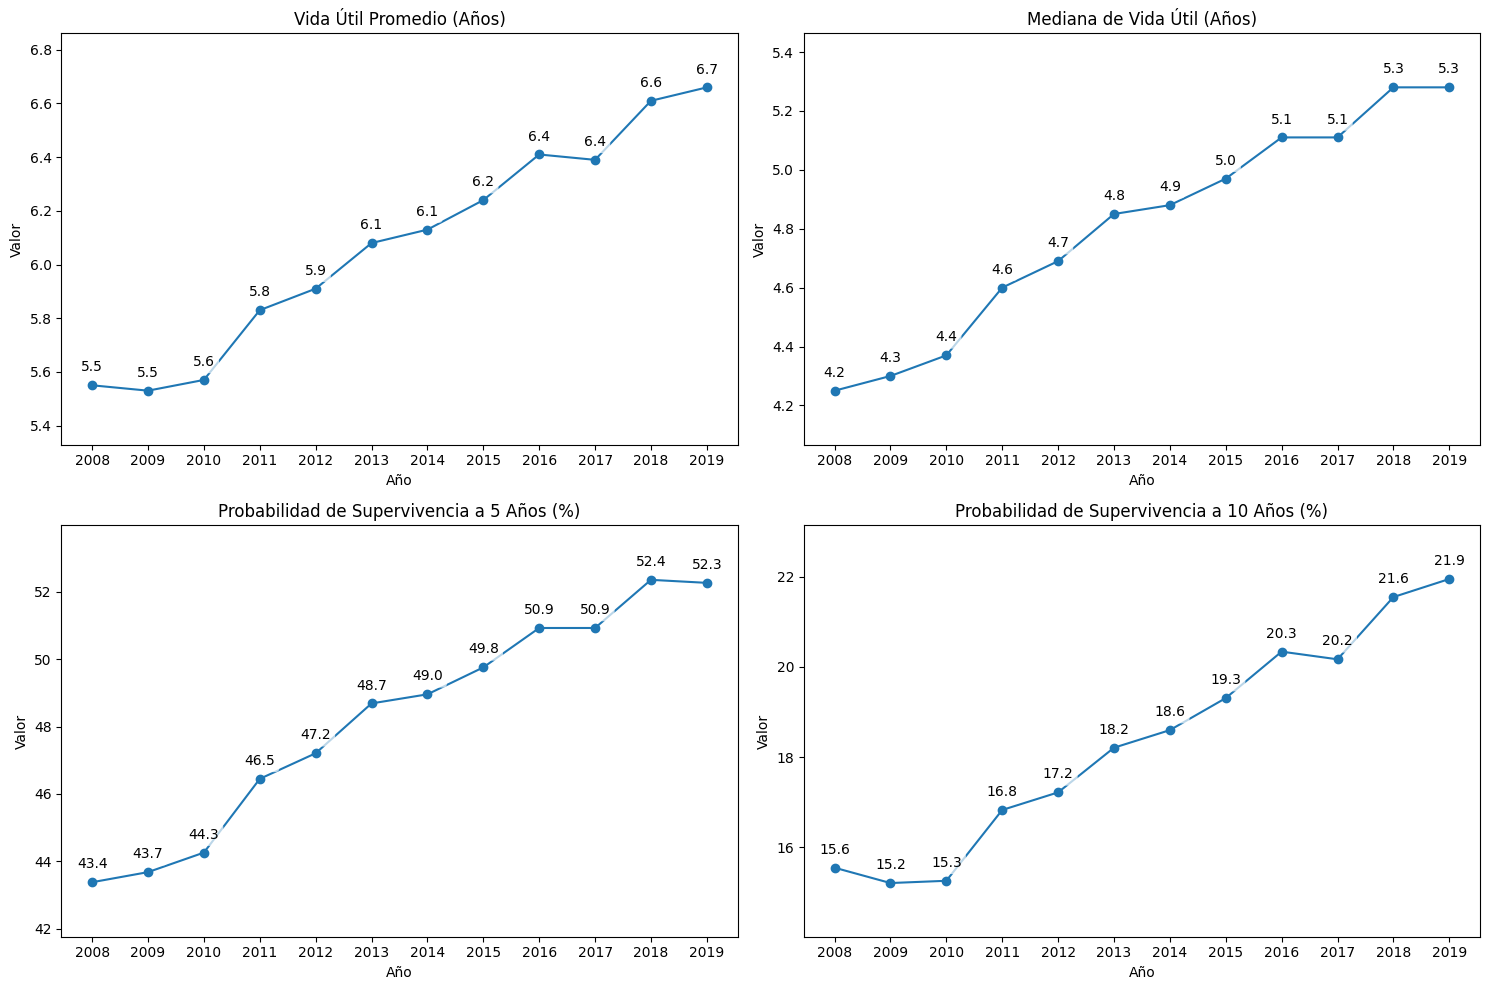

In [ ]:
max_vals_plus_std = {
    column: df_resultados[column].max() + 0.5*df_resultados[column].std()
    for column in df_resultados.columns
}

# Calculando el máximo valor más 2 desviaciones estándar para cada serie de datos
min_vals_plus_std = {
    column: df_resultados[column].min() - 0.5*df_resultados[column].std()
    for column in df_resultados.columns
}


# Crear los gráficos nuevamente con todos los años en el eje x y sombreado blanco con transparencia del 70%
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
df_resultados['Vida Útil Promedio'].plot(ax=ax[0,0], title='Vida Útil Promedio (Años)', marker='o')
df_resultados['Mediana de Vida Útil'].plot(ax=ax[0,1], title='Mediana de Vida Útil (Años)', marker='o')
df_resultados['Probabilidad de Supervivencia a 5 Años'].plot(ax=ax[1,0], title='Probabilidad de Supervivencia a 5 Años (%)', marker='o')
df_resultados['Probabilidad de Supervivencia a 10 Años'].plot(ax=ax[1,1], title='Probabilidad de Supervivencia a 10 Años (%)', marker='o')

# Ajustar los límites del eje y y sombrear los valores
for a, column in zip(ax.flat, df_resultados.columns):
    a.set_ylim([min_vals_plus_std[column], max_vals_plus_std[column]])
    a.set_xticks(df_resultados.index)
    for i in df_resultados.index:
        a.annotate(f'{df_resultados.loc[i, column]:.1f}',
                   (i, df_resultados.loc[i, column]),
                   textcoords="offset points",
                   xytext=(0,10),
                   ha='center',
                   bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7, lw=0))

    a.set_xlabel('Año')
    a.set_ylabel('Valor')
    a.grid(False)

plt.tight_layout()
plt.show()


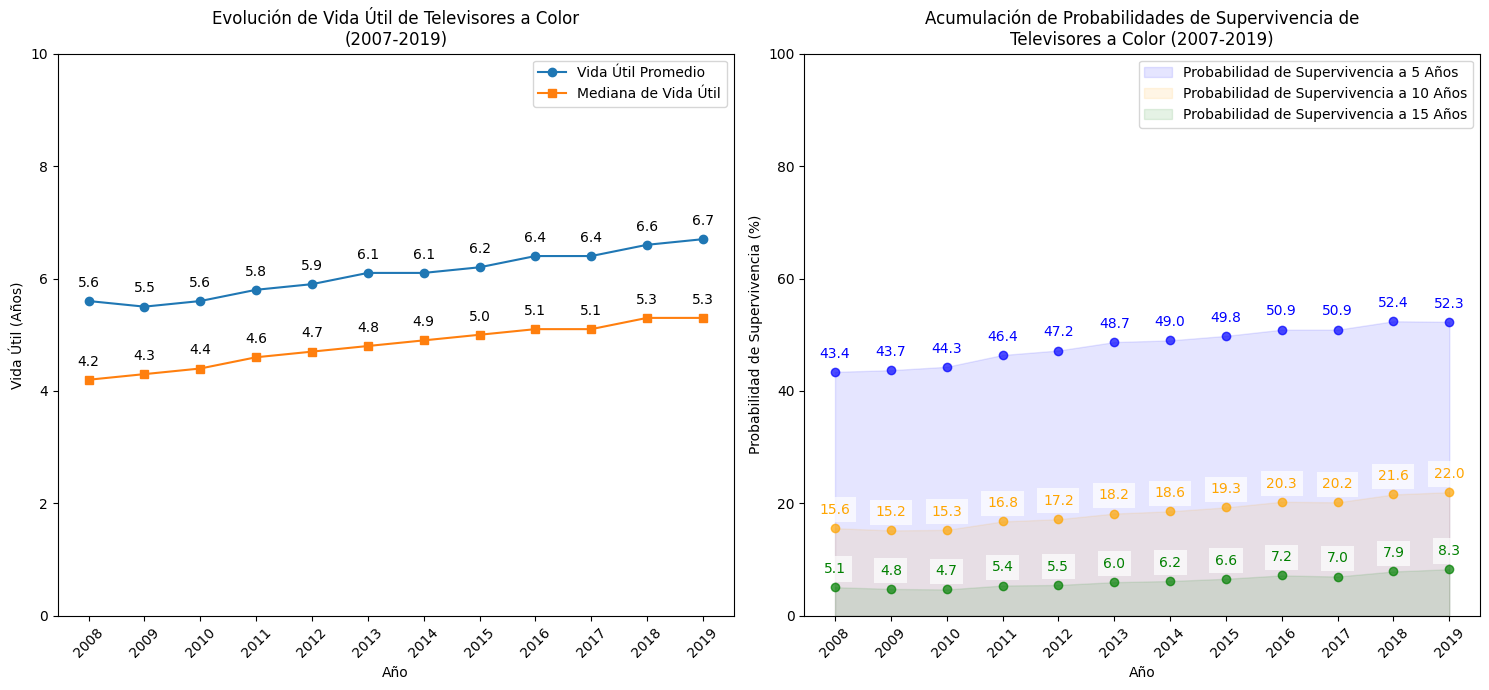

In [ ]:
# Crear los dos gráficos en una matriz 1x2 con un separador y un salto de línea en el título largo

plt.figure(figsize=(15, 7))

# Primer gráfico (Vida Útil)
plt.subplot(1, 2, 1)
plt.plot(df_resultados.index, df_resultados['Vida Útil Promedio'].round(1), label='Vida Útil Promedio', marker='o')
plt.plot(df_resultados.index, df_resultados['Mediana de Vida Útil'].round(1), label='Mediana de Vida Útil', marker='s')

# Anotaciones para el primer gráfico
for x, y in zip(df_resultados.index, df_resultados['Vida Útil Promedio'].round(1)):
    plt.text(x, y + 0.2, str(y), fontsize=10, verticalalignment='bottom', horizontalalignment='center',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
for x, y in zip(df_resultados.index, df_resultados['Mediana de Vida Útil'].round(1)):
    plt.text(x, y + 0.2, str(y), fontsize=10, verticalalignment='bottom', horizontalalignment='center',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.title('Evolución de Vida Útil de Televisores a Color\n(2007-2019)')
plt.xlabel('Año')
plt.ylabel('Vida Útil (Años)')
plt.ylim(0, 10)  # Ajusta el eje Y para mostrar hasta 10 unidades
plt.legend()
plt.grid(False)
plt.xticks(df_resultados.index, rotation=45)

# Agregamos un separador visual entre los gráficos
plt.subplots_adjust(wspace=0.3)

# Segundo gráfico (Probabilidad de Supervivencia)
plt.subplot(1, 2, 2)
for i, columna in enumerate(['Probabilidad de Supervivencia a 5 Años',
                             'Probabilidad de Supervivencia a 10 Años',
                             'Probabilidad de Supervivencia a 15 Años']):
    color = ['blue', 'orange', 'green'][i]
    y_values = df_resultados[columna].round(1)
    plt.fill_between(df_resultados.index, 0, y_values, label=columna, alpha=0.1, color=color)
    plt.scatter(df_resultados.index, y_values, color=color, alpha=0.7, zorder=3)
    for x, y in zip(df_resultados.index, y_values):
        plt.text(x, y + 2, str(y), fontsize=10, verticalalignment='bottom', horizontalalignment='center',
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'), color=color)

plt.title('Acumulación de Probabilidades de Supervivencia de\nTelevisores a Color (2007-2019)')
plt.xlabel('Año')
plt.ylabel('Probabilidad de Supervivencia (%)')
plt.ylim(0, 100)  # Ajusta el eje Y para mostrar hasta 100 unidades
plt.legend()
plt.grid(False)
plt.xticks(df_resultados.index, rotation=45)

plt.tight_layout()
plt.show()

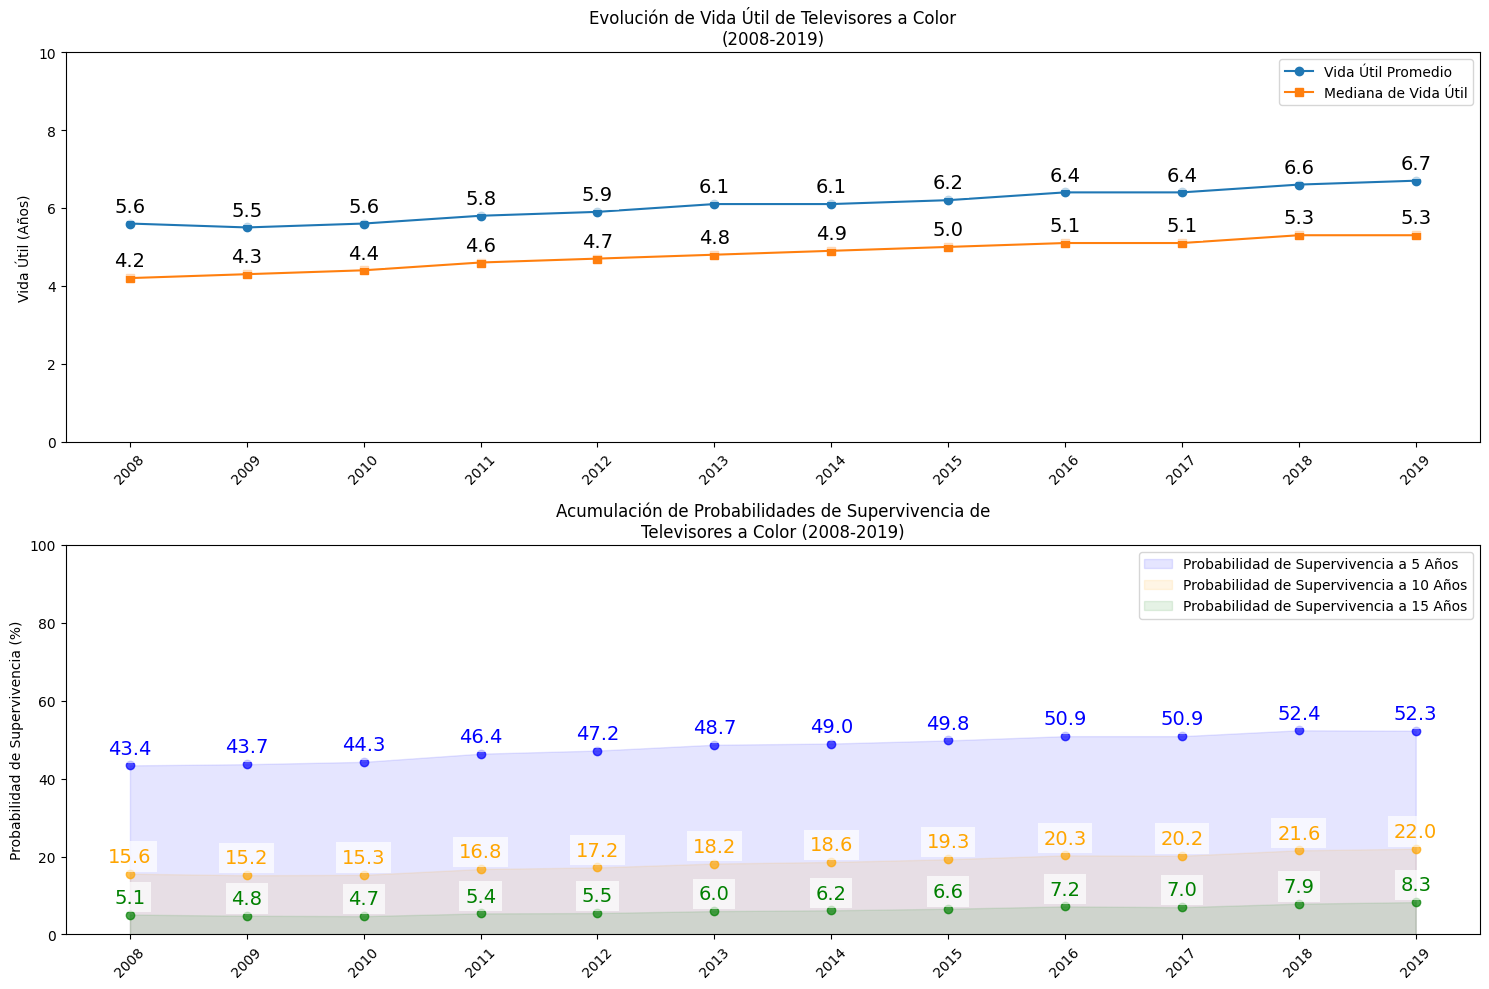

In [ ]:
# Crear los dos gráficos en una matriz 1x2 con un separador y un salto de línea en el título largo

plt.figure(figsize=(15, 10))

# Primer gráfico (Vida Útil)
plt.subplot(2, 1, 1)
plt.plot(df_resultados.index, df_resultados['Vida Útil Promedio'].round(1), label='Vida Útil Promedio', marker='o')
plt.plot(df_resultados.index, df_resultados['Mediana de Vida Útil'].round(1), label='Mediana de Vida Útil', marker='s')

# Anotaciones para el primer gráfico
for x, y in zip(df_resultados.index, df_resultados['Vida Útil Promedio'].round(1)):
    plt.text(x, y + 0.2, str(y), fontsize=14, verticalalignment='bottom', horizontalalignment='center',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
for x, y in zip(df_resultados.index, df_resultados['Mediana de Vida Útil'].round(1)):
    plt.text(x, y + 0.2, str(y), fontsize=14, verticalalignment='bottom', horizontalalignment='center',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.title('Evolución de Vida Útil de Televisores a Color\n(2008-2019)')
# plt.xlabel('Año')
plt.ylabel('Vida Útil (Años)')
plt.ylim(0, 10)  # Ajusta el eje Y para mostrar hasta 10 unidades
plt.legend()
plt.grid(False)
plt.xticks(df_resultados.index, rotation=45)

# Agregamos un separador visual entre los gráficos
plt.subplots_adjust(wspace=0.3)

# Segundo gráfico (Probabilidad de Supervivencia)
plt.subplot(2, 1, 2)
for i, columna in enumerate(['Probabilidad de Supervivencia a 5 Años',
                             'Probabilidad de Supervivencia a 10 Años',
                             'Probabilidad de Supervivencia a 15 Años']):
    color = ['blue', 'orange', 'green'][i]
    y_values = df_resultados[columna].round(1)
    plt.fill_between(df_resultados.index, 0, y_values, label=columna, alpha=0.1, color=color)
    plt.scatter(df_resultados.index, y_values, color=color, alpha=0.7, zorder=3)
    for x, y in zip(df_resultados.index, y_values):
        plt.text(x, y + 2, str(y), fontsize=14, verticalalignment='bottom', horizontalalignment='center',
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'), color=color)

plt.title('Acumulación de Probabilidades de Supervivencia de\nTelevisores a Color (2008-2019)')
# plt.xlabel('Año')
plt.ylabel('Probabilidad de Supervivencia (%)')
plt.ylim(0, 100)  # Ajusta el eje Y para mostrar hasta 100 unidades
plt.legend()
plt.grid(False)
plt.xticks(df_resultados.index, rotation=45)

plt.tight_layout()
plt.show()


##### Graficos de Bland-Altman

In [ ]:
new_columnas_interes = ['Lambda','Rho']
df1_full = df_resultados_completo[new_columnas_interes]
df1_full = df1_full.reset_index()
df1_full.rename(columns={'index': 'Año'}, inplace=True)

In [ ]:
import pandas as pd
from scipy.special import gamma

# Calcular la media y la varianza de la Weibull
df1_full['Mu'] = df1_full['Lambda'] * gamma(1 + 1/df1_full['Rho'])
df1_full['Sigma2'] = (df1_full['Lambda']**2) * (gamma(1 + 2/df1_full['Rho']) - (gamma(1 + 1/df1_full['Rho']))**2)

df1_full

,Año,Lambda,Rho,Mu,Sigma2
0,2008,5.84,1.16,5.544105,22.975340
1,2009,5.86,1.18,5.536771,22.173897
2,2010,5.92,1.21,5.556929,21.287986
3,2011,6.22,1.22,5.826604,23.039839
4,2012,6.31,1.23,5.899226,23.253523
5,2013,6.51,1.24,6.074560,24.279736
6,2014,6.56,1.24,6.121216,24.654129
7,2015,6.69,1.24,6.242520,25.640956
8,2016,6.87,1.24,6.410480,27.039301
9,2017,6.86,1.25,6.389293,26.454499


In [ ]:
df2_full = pd.DataFrame({
    "Año": [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
    "Lambda": [12.58, 7.39, 13.49, 6.03, 5.54, 5.07, 5.20, 5.31, 5.70, 5.84, 6.14, 6.12, 6.23, 6.35, 6.31, 6.57, 6.55],
    "Rho": [1.34, 1.24, 1.28, 1.21, 1.25, 1.32, 1.34, 1.36, 1.33, 1.33, 1.33, 1.32, 1.35, 1.35, 1.36, 1.32, 1.33],
    "Mu": [11.55, 6.90, 12.51, 5.66, 5.16, 4.67, 4.78, 4.86, 5.24, 5.37, 5.64, 5.64, 5.71, 5.83, 5.78, 6.04, 6.02],
    "Sigma2": [75.56, 31.28, 97.69, 22.22, 17.37, 12.67, 13.01, 12.99, 15.86, 16.65, 18.42, 18.69, 18.34, 19.13, 18.54, 21.28, 20.94]
})

label1 = 'Basadas en el Estimador KM'
label2 = 'Encuesta ENAHO, pregunta 612C'

In [ ]:
df1_full = df1_full[df1_full["Año"]>=2008]
df2_full = df2_full[df2_full["Año"]>=2008]

In [ ]:
df1_full.columns

Index(['Año', 'Lambda', 'Rho', 'Mu', 'Sigma2'], dtype='object')

In [ ]:
df2_full.columns

Index(['Año', 'Lambda', 'Rho', 'Mu', 'Sigma2'], dtype='object')

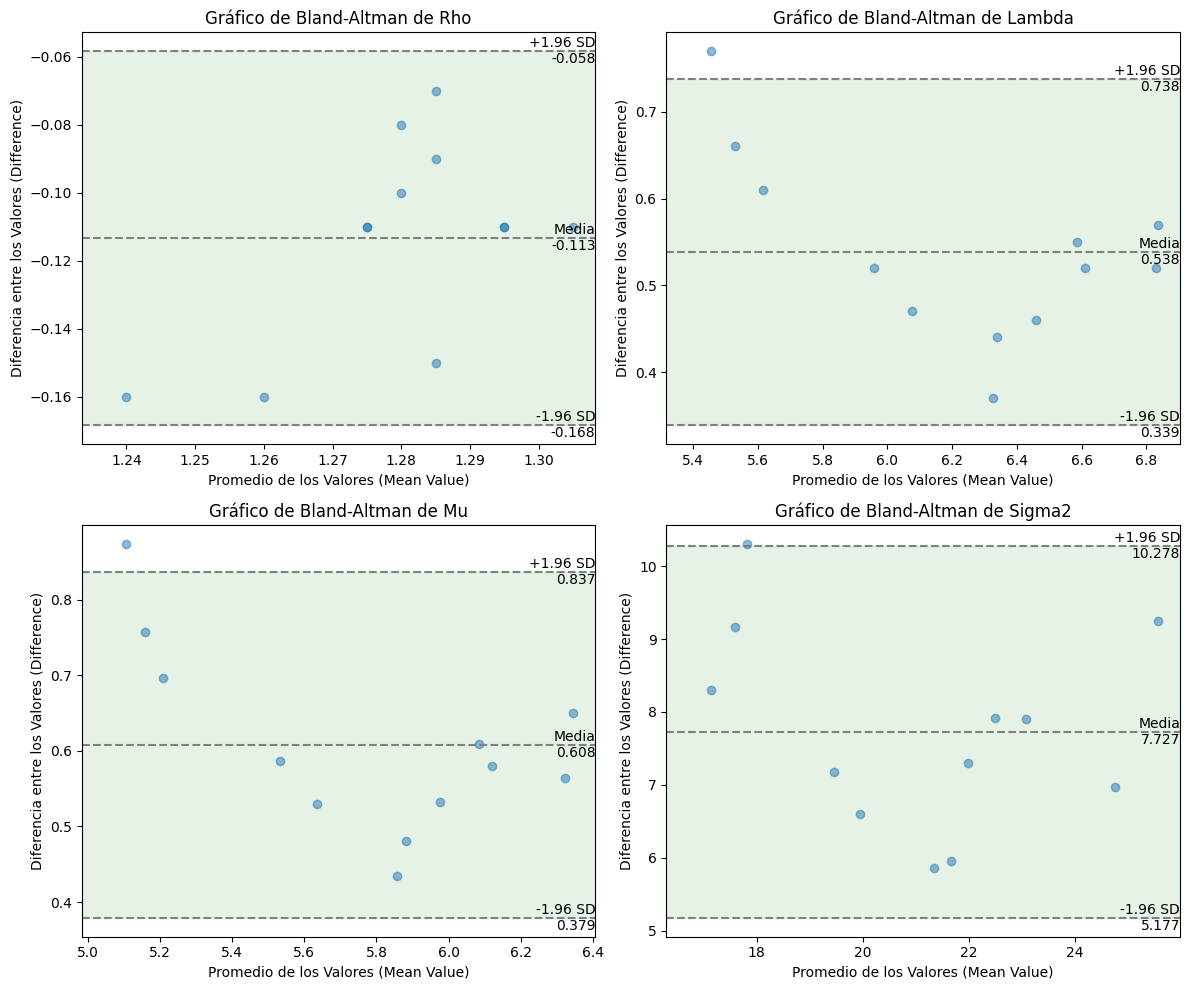

In [ ]:
def bland_altman_plot_improved_with_titles(data1, data2, ax, title):
    data1 = np.asarray(data1)
    data2 = np.asarray(data2)
    mean = np.mean([data1, data2], axis=0)
    diff = data1 - data2
    md = np.mean(diff)
    sd = np.std(diff, axis=0)

    upper_limit = md + 1.96*sd
    lower_limit = md - 1.96*sd

    # Resaltar las áreas fuera de los límites
    ax.fill_betweenx([lower_limit, upper_limit], min(mean) - 0.1 * np.ptp(mean), max(mean) + 0.1 * np.ptp(mean), color='green', alpha=0.1)

    ax.scatter(mean, diff, alpha=0.5)
    ax.axhline(md, color='gray', linestyle='--')
    ax.axhline(upper_limit, color='gray', linestyle='--')
    ax.axhline(lower_limit, color='gray', linestyle='--')

    # Anotaciones en el extremo derecho
    annotation_x_position = max(mean) + 0.05 * np.ptp(mean)
    ax.text(annotation_x_position, md, f'Media\n{md:.3f}', va='center', ha='right')
    ax.text(annotation_x_position, upper_limit, f'+1.96 SD\n{upper_limit:.3f}', va='center', ha='right')
    ax.text(annotation_x_position, lower_limit, f'-1.96 SD\n{lower_limit:.3f}', va='center', ha='right')

    ax.set_title(title)
    ax.set_xlabel('Promedio de los Valores (Mean Value)')
    ax.set_ylabel('Diferencia entre los Valores (Difference)')
    ax.grid(False)

    # Expandir el eje x para acomodar anotaciones
    ax.set_xlim(min(mean) - 0.1 * np.ptp(mean), annotation_x_position)

# Creación de la matriz de gráficos 2x2 con títulos personalizados
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

variables = ['Rho', 'Lambda', 'Mu', 'Sigma2']
for i, var in enumerate(variables):
    title = f"Gráfico de Bland-Altman de {var}"
    bland_altman_plot_improved_with_titles(df1_full[var], df2_full[var], axs[i//2, i%2], title)

plt.tight_layout()
plt.show()

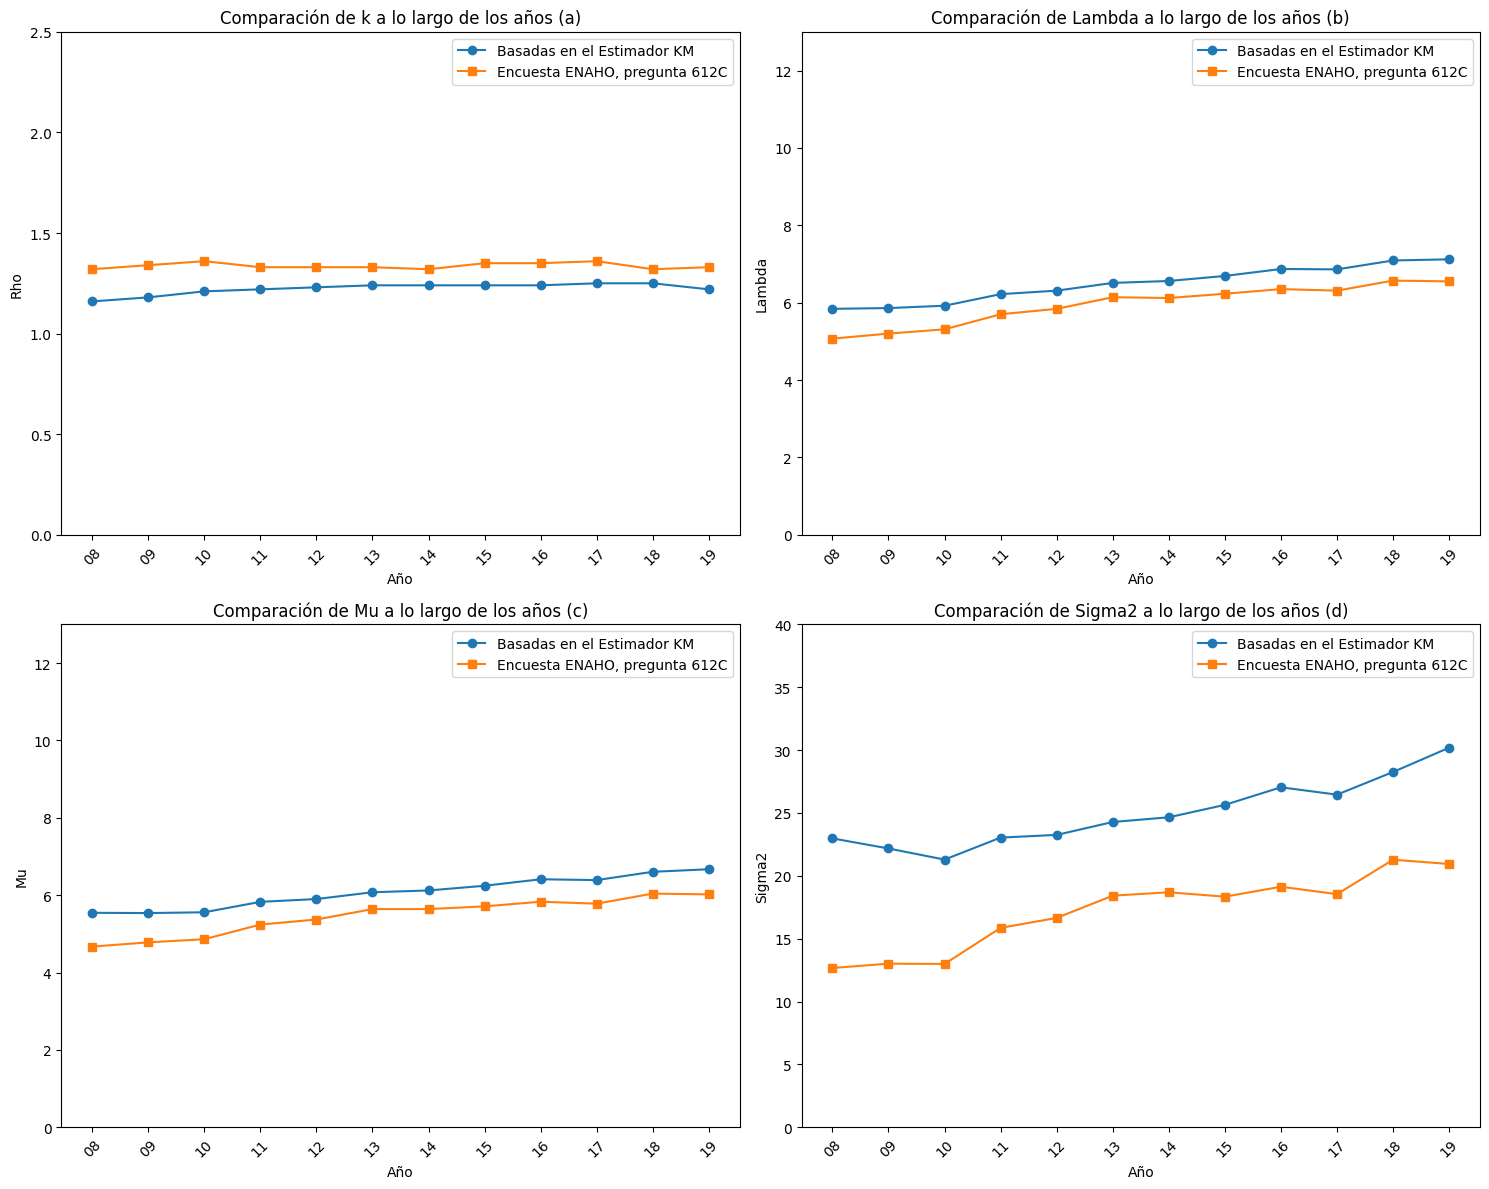

In [ ]:
# Creando una matriz de gráficos 2x2 para las diferentes comparaciones
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Abreviando los años para el eje x
abreviatura_años = [str(año)[2:] for año in df1_full['Año']]

# Gráfico de comparación para 'k'
comparison_df_k = df1_full[['Año', 'Rho']].merge(df2_full[['Año', 'Rho']], on='Año', suffixes=('_data1', '_data2'))
axs[0, 0].plot(comparison_df_k['Año'], comparison_df_k['Rho_data1'], label=label1, marker='o')
axs[0, 0].plot(comparison_df_k['Año'], comparison_df_k['Rho_data2'], label=label2, marker='s')
axs[0, 0].set_title('Comparación de k a lo largo de los años (a)')
axs[0, 0].set_xlabel('Año')
axs[0, 0].set_ylabel('Rho')
axs[0, 0].set_ylim(0, 2.5)
axs[0, 0].legend()
axs[0, 0].grid(False)
axs[0, 0].set_xticks(df1_full['Año'])
axs[0, 0].set_xticklabels(abreviatura_años, rotation=45)

# Gráfico de comparación para 'lambda'
comparison_df_lambda = df1_full[['Año', 'Lambda']].merge(df2_full[['Año', 'Lambda']], on='Año', suffixes=('_data1', '_data2'))
axs[0, 1].plot(comparison_df_lambda['Año'], comparison_df_lambda['Lambda_data1'], label=label1, marker='o')
axs[0, 1].plot(comparison_df_lambda['Año'], comparison_df_lambda['Lambda_data2'], label=label2, marker='s')
axs[0, 1].set_title('Comparación de Lambda a lo largo de los años (b)')
axs[0, 1].set_xlabel('Año')
axs[0, 1].set_ylabel('Lambda')
axs[0, 1].set_ylim(0, 13)
axs[0, 1].legend()
axs[0, 1].grid(False)
axs[0, 1].set_xticks(df1_full['Año'])
axs[0, 1].set_xticklabels(abreviatura_años, rotation=45)

# Gráfico de comparación para 'mu'
comparison_df_mu = df1_full[['Año', 'Mu']].merge(df2_full[['Año', 'Mu']], on='Año', suffixes=('_data1', '_data2'))
axs[1, 0].plot(comparison_df_mu['Año'], comparison_df_mu['Mu_data1'], label=label1, marker='o')
axs[1, 0].plot(comparison_df_mu['Año'], comparison_df_mu['Mu_data2'], label=label2, marker='s')
axs[1, 0].set_title('Comparación de Mu a lo largo de los años (c)')
axs[1, 0].set_xlabel('Año')
axs[1, 0].set_ylabel('Mu')
axs[1, 0].set_ylim(0, 13)
axs[1, 0].legend()
axs[1, 0].grid(False)
axs[1, 0].set_xticks(df1_full['Año'])
axs[1, 0].set_xticklabels(abreviatura_años, rotation=45)

# Gráfico de comparación para 'sigma2'
comparison_df_sigma2 = df1_full[['Año', 'Sigma2']].merge(df2_full[['Año', 'Sigma2']], on='Año', suffixes=('_data1', '_data2'))
axs[1, 1].plot(comparison_df_sigma2['Año'], comparison_df_sigma2['Sigma2_data1'], label=label1, marker='o')
axs[1, 1].plot(comparison_df_sigma2['Año'], comparison_df_sigma2['Sigma2_data2'], label=label2, marker='s')
axs[1, 1].set_title('Comparación de Sigma2 a lo largo de los años (d)')
axs[1, 1].set_xlabel('Año')
axs[1, 1].set_ylabel('Sigma2')
axs[1, 1].set_ylim(0, 40)
axs[1, 1].legend()
axs[1, 1].grid(False)
axs[1, 1].set_xticks(df1_full['Año'])
axs[1, 1].set_xticklabels(abreviatura_años, rotation=45)


plt.tight_layout()
plt.show()


##### Sumarias

In [ ]:
import pandas as pd

# Asume que tienes una función que devuelve la ruta del archivo correcta basada en el año
def get_file_path(year):
    return f'/content/drive/MyDrive/Bases de datos/Sumaria/Sumaria-{year}.csv'

# Diccionario para almacenar las medias de cada año
medias_por_año = {}

# Bucle para procesar cada año desde 2008 hasta 2019
for year in range(2008, 2020):
    file_path = get_file_path(year)
    data = pd.read_csv(file_path, encoding='latin1')

    # Calcular la media de todas las variables
    medias = data.mean()

    # Almacenar las medias en el diccionario
    medias_por_año[year] = medias

# Convertir el diccionario a DataFrame para un manejo más fácil
df_medias = pd.DataFrame.from_dict(medias_por_año)

# Transponer el DataFrame para mejor visualización
df_medias = df_medias.T

<ipython-input-39-8d5bf03d3f4d>:13: DtypeWarning: Columns (15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path, encoding='latin1')
<ipython-input-39-8d5bf03d3f4d>:16: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  medias = data.mean()
<ipython-input-39-8d5bf03d3f4d>:16: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  medias = data.mean()


##### ML

In [ ]:
!pip install scikit-learn

In [ ]:
import sklearn
print(sklearn.__version__)

1.2.2


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Cargando y procesando el dataframe suplementario
data_suplemen = pd.read_csv("/content/drive/MyDrive/Bases de datos/Suplementario/Data_Suplemental_converted.csv", encoding='latin1')
data_suplemen_transpuesta = data_suplemen.T
data_suplemen_transpuesta.columns = data_suplemen_transpuesta.iloc[0]
data_suplemen_transpuesta = data_suplemen_transpuesta.drop(data_suplemen_transpuesta.index[0])

# Transponiendo y limpiando los dataframes
df_medias_transpuesta = df_medias.T.replace(0, np.nan).dropna(how='any')

#===========================#===========================#===========================

codigos_filtrados = ["GRU41HD", "GRU42HD1", "GRU42HD2", "GRU43HD1", "GRU43HD2", "GRU43HD3", "GRU44HD",
                     "INGMO1HD", "INGMO2HD", "INGHOG1D", "INGHOG2D", "GASHOG1D", "GASHOG2D",
                     "SG42", "SG42D", "SG421", "SG42D1", "SG422", "SG42D2", "SG423", "SG42D3"]

#===========================#===========================#===========================

df_medias_transpuesta = df_medias_transpuesta[df_medias_transpuesta.index.isin(codigos_filtrados)]
df_final = pd.concat([data_suplemen_transpuesta, df_medias_transpuesta])
df_final_sin_duplicados = df_final.drop_duplicates().T

# Filtrando por índice si es necesario
df_final_sin_duplicados = df_final_sin_duplicados[df_final_sin_duplicados.index >= 2008]

In [ ]:
# Quitar espacios en los valores y reemplazar comas por puntos, luego convertir a numérico
for col in df_final_sin_duplicados.columns:
    df_final_sin_duplicados[col] = df_final_sin_duplicados[col].astype(str).str.replace(',', '.').str.strip()

for col in df_final_sin_duplicados.columns:
    # Eliminar espacios dentro de las cadenas numéricas
    df_final_sin_duplicados[col] = df_final_sin_duplicados[col].astype(str).str.replace(' ', '').str.replace(',', '.')

    # Convertir a numérico
    df_final_sin_duplicados[col] = pd.to_numeric(df_final_sin_duplicados[col], errors='coerce')

# Identificar y manejar columnas no numéricas
df_no_numericas = pd.DataFrame()
non_numeric_columns = df_final_sin_duplicados.select_dtypes(exclude=[np.number]).columns

for col in non_numeric_columns:
    # Convertir a numérico, marcando no convertibles como NaN
    converted = pd.to_numeric(df_final_sin_duplicados[col], errors='coerce')
    if converted.isna().any():
        df_no_numericas[col] = df_final_sin_duplicados[col]
        df_final_sin_duplicados.drop(col, axis=1, inplace=True)
    else:
        df_final_sin_duplicados[col] = converted

df_no_numericas.dropna(how='all', axis=1, inplace=True)

print("\nDataFrame con columnas no completamente numéricas:")
print(df_no_numericas.info())


DataFrame con columnas no completamente numéricas:
<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Empty DataFrame
None


In [ ]:
# Normalización de los datos
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_final_sin_duplicados), columns=df_final_sin_duplicados.columns)

y = df_resultados['Vida Útil Promedio']
y = y.astype('float64')

In [ ]:
df_final_sin_duplicados.T

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Total Population,2.880703e+07,2.913201e+07,2.946193e+07,2.979769e+07,3.013588e+07,3.047514e+07,3.081418e+07,3.115164e+07,3.148862e+07,3.182602e+07,3.216218e+07,3.249551e+07
Households (ENAHO),2.264000e+04,2.264000e+04,2.264000e+04,2.645600e+04,2.645600e+04,3.169000e+04,3.169000e+04,3.343000e+04,3.829600e+04,3.699600e+04,3.982000e+04,3.699400e+04
Surveyed Population (ENAHO),9.454700e+04,9.644000e+04,9.514900e+04,1.058400e+05,1.039700e+05,1.240380e+05,1.241540e+05,1.274740e+05,1.384270e+05,1.326570e+05,1.396570e+05,1.282760e+05
GDP %,9.140000e+00,1.050000e+00,8.450000e+00,6.450000e+00,5.950000e+00,5.840000e+00,2.390000e+00,3.270000e+00,4.040000e+00,2.470000e+00,3.990000e+00,2.200000e+00
"GDP, million PEN",3.489230e+05,3.525840e+05,3.823800e+05,4.070520e+05,4.312730e+05,4.564490e+05,4.673760e+05,4.826760e+05,5.021910e+05,5.146540e+05,5.352550e+05,5.467310e+05
PEN/USD exchange rate,2.924000e+00,2.824000e+00,2.824000e+00,2.753000e+00,2.637000e+00,2.701000e+00,2.837000e+00,3.182000e+00,3.373000e+00,3.258000e+00,3.285000e+00,3.335000e+00
Color TV - Imports,1.168448e+06,8.659040e+05,1.356317e+06,1.596631e+06,1.536196e+06,1.624690e+06,1.729125e+06,1.380080e+06,1.578653e+06,1.517939e+06,1.863271e+06,1.674567e+06
"Color TV - mmass, kg",1.916900e+01,1.575500e+01,1.352900e+01,1.324300e+01,1.214400e+01,1.043300e+01,1.012500e+01,9.071000e+00,9.645000e+00,1.087900e+01,1.113600e+01,1.133200e+01
"Color TV - smass, kg",8.329000e+00,7.840000e+00,7.044000e+00,7.100000e+00,1.328000e+01,6.376000e+00,7.050000e+00,6.588000e+00,6.322000e+00,8.358000e+00,7.750000e+00,1.367700e+01
Color TV - 0 (%),4.262000e+01,3.786000e+01,3.499000e+01,3.281000e+01,3.090000e+01,2.932000e+01,2.895000e+01,2.650000e+01,2.570000e+01,2.720000e+01,2.828000e+01,2.728000e+01


##### Selección de Características

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso


# Cargar y preparar los datos
# Asumiendo df_scaled como el DataFrame de características ya escaladas y 'y' como el vector objetivo
# df_scaled, y = ...

# Inicialización de modelos
models = {
    'Lasso': Lasso(alpha=0.01),
    'SVM': SVR(kernel='linear'),  # Ajusta los parámetros según sea necesario
    'RandomForest': RandomForestRegressor(n_estimators=100)}


# Inicializar LeaveOneOut
loo = LeaveOneOut()

# Seleccionar las mejores k características con SelectKBest
k = 16  # Ajusta el número de características según necesidad
selector_kbest = SelectKBest(f_regression, k=k)
X_kbest_selected = selector_kbest.fit_transform(df_scaled, y)
X_kbest = pd.DataFrame(X_kbest_selected, columns=df_scaled.columns[selector_kbest.get_support()])

# Inicializar el modelo RandomForest para la selección de características
rf = RandomForestRegressor(n_estimators=100)
rf.fit(df_scaled, y)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Seleccionar las características más importantes según RandomForest
X_rf_selected = df_scaled.iloc[:, indices[:k]]
X_rf = pd.DataFrame(X_rf_selected, columns=df_scaled.columns[indices[:k]])


# Diccionario para almacenar resultados
results = {}

# Adaptación del ciclo de validación cruzada para incluir métricas de entrenamiento
for name, model in models.items():
    for feature_set, X in [('SelectKBest', X_kbest), ('RandomForest', X_rf)]:
        # Inicializar listas para almacenar métricas
        train_metrics = {'MSE': [], 'RMSE': [], 'MAE': []}
        val_metrics = {'MSE': [], 'RMSE': [], 'MAE': []}

        for train_index, test_index in loo.split(X):
            # Dividir en conjuntos de entrenamiento y validación
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Entrenar el modelo
            model.fit(X_train, y_train)

            # Predicciones en entrenamiento y validación
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            # Calcular y almacenar métricas de entrenamiento
            train_metrics['MSE'].append(mean_squared_error(y_train, y_train_pred))
            train_metrics['RMSE'].append(np.sqrt(train_metrics['MSE'][-1]))
            train_metrics['MAE'].append(mean_absolute_error(y_train, y_train_pred))

            # Calcular y almacenar métricas de validación
            val_metrics['MSE'].append(mean_squared_error(y_test, y_test_pred))
            val_metrics['RMSE'].append(np.sqrt(val_metrics['MSE'][-1]))
            val_metrics['MAE'].append(mean_absolute_error(y_test, y_test_pred))

        # Calcular promedios de métricas
        for metric in train_metrics:
            train_metrics[metric] = np.mean(train_metrics[metric])
            val_metrics[metric] = np.mean(val_metrics[metric])

        # Almacenar en resultados
        results[f'{feature_set}_{name}_Train'] = train_metrics
        results[f'{feature_set}_{name}_Val'] = val_metrics

# Imprimir resultados con métricas de entrenamiento y validación
for key, metrics in results.items():
    print(f"{key}: MSE={metrics['MSE']:.4f}, RMSE={metrics['RMSE']:.4f}, MAE={metrics['MAE']:.4f}")


SelectKBest_Lasso_Train: MSE=0.0015, RMSE=0.0385, MAE=0.0293
SelectKBest_Lasso_Val: MSE=0.0046, RMSE=0.0484, MAE=0.0484
RandomForest_Lasso_Train: MSE=0.0013, RMSE=0.0357, MAE=0.0276
RandomForest_Lasso_Val: MSE=0.0043, RMSE=0.0478, MAE=0.0478
SelectKBest_SVM_Train: MSE=0.0045, RMSE=0.0667, MAE=0.0591
SelectKBest_SVM_Val: MSE=0.0063, RMSE=0.0664, MAE=0.0664
RandomForest_SVM_Train: MSE=0.0060, RMSE=0.0777, MAE=0.0683
RandomForest_SVM_Val: MSE=0.0087, RMSE=0.0776, MAE=0.0776
SelectKBest_RandomForest_Train: MSE=0.0013, RMSE=0.0354, MAE=0.0279
SelectKBest_RandomForest_Val: MSE=0.0088, RMSE=0.0745, MAE=0.0745
RandomForest_RandomForest_Train: MSE=0.0016, RMSE=0.0393, MAE=0.0325
RandomForest_RandomForest_Val: MSE=0.0110, RMSE=0.0884, MAE=0.0884


###### SelectKBest

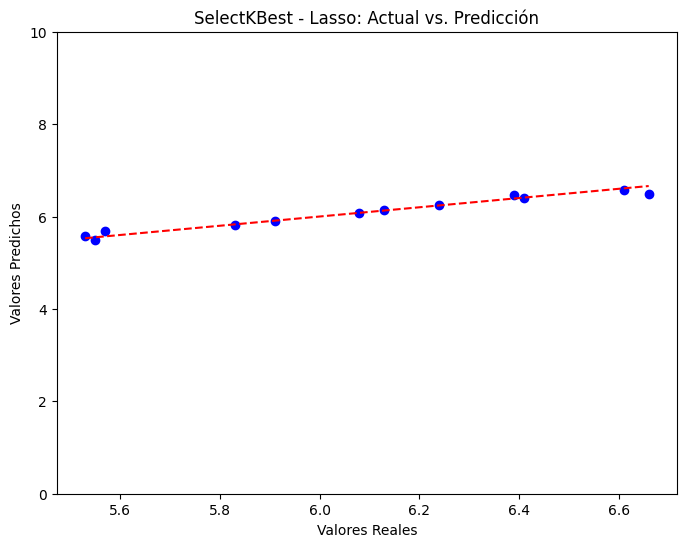

Lasso R-cuadrado: 0.97


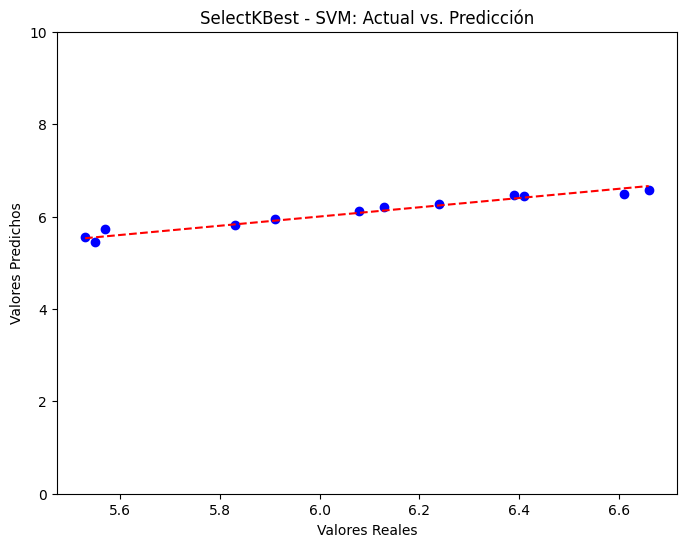

SVM R-cuadrado: 0.96


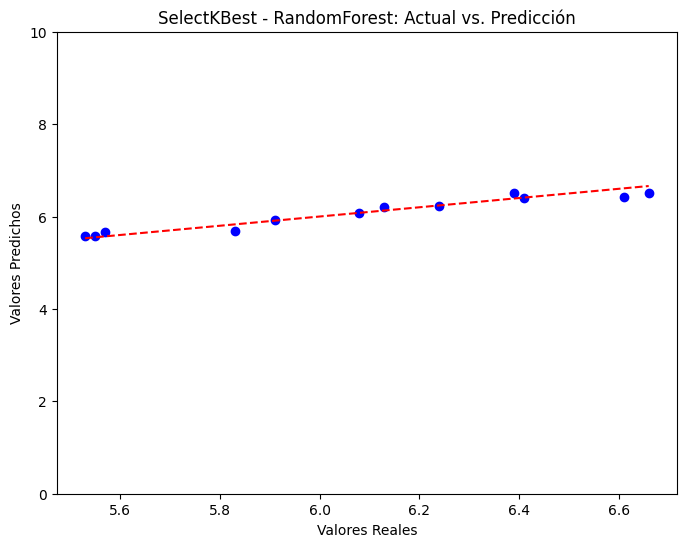

RandomForest R-cuadrado: 0.94


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso


# Cargar y preparar los datos
# Asumiendo df_scaled como el DataFrame de características ya escaladas y 'y' como el vector objetivo
# df_scaled, y = ...

# Inicializar LeaveOneOut
loo = LeaveOneOut()

# Seleccionar las mejores k características con SelectKBest
k = 16  # Asumiendo que k=16 es el número óptimo de características
selector = SelectKBest(f_regression, k=k)
X_selected = selector.fit_transform(df_scaled, y)


# Inicialización de modelos
models = {
    'Lasso': Lasso(alpha=0.01),
    'SVM': SVR(kernel='linear'),  # Ajusta los parámetros según sea necesario
    'RandomForest': RandomForestRegressor(n_estimators=100)}


# Función para realizar validación cruzada Leave-One-Out y generar gráficos
def loo_cross_validation_and_plot(models, X, y, title_prefix):
    for name, model in models.items():
        y_real, y_pred = [], []
        for train_index, test_index in loo.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Entrenar el modelo
            model.fit(X_train, y_train)

            # Realizar predicciones
            predictions = model.predict(X_test)

            # Almacenar valores reales y predichos
            y_real.extend(y_test)
            y_pred.extend(predictions)

        # Graficar Actual vs. Predicción
        plt.figure(figsize=(8, 6))
        plt.scatter(y_real, y_pred, color='blue')
        plt.plot([min(y_real), max(y_real)], [min(y_real), max(y_real)], color='red', linestyle='--')
        plt.title(f'{title_prefix} - {name}: Actual vs. Predicción')
        plt.xlabel('Valores Reales')
        plt.ylabel('Valores Predichos')

        # Establecer límites del gráfico para comenzar en 0
        plt.ylim(0, 10)  # Ajusta el eje Y para mostrar hasta 100 unidades

        plt.show()

        # Calcular y mostrar R-cuadrado
        r2 = r2_score(y_real, y_pred)
        print(f'{name} R-cuadrado: {r2:.2f}')

# Ejecutar la validación cruzada y generar gráficos para cada modelo
loo_cross_validation_and_plot(models, X_selected, y, 'SelectKBest')

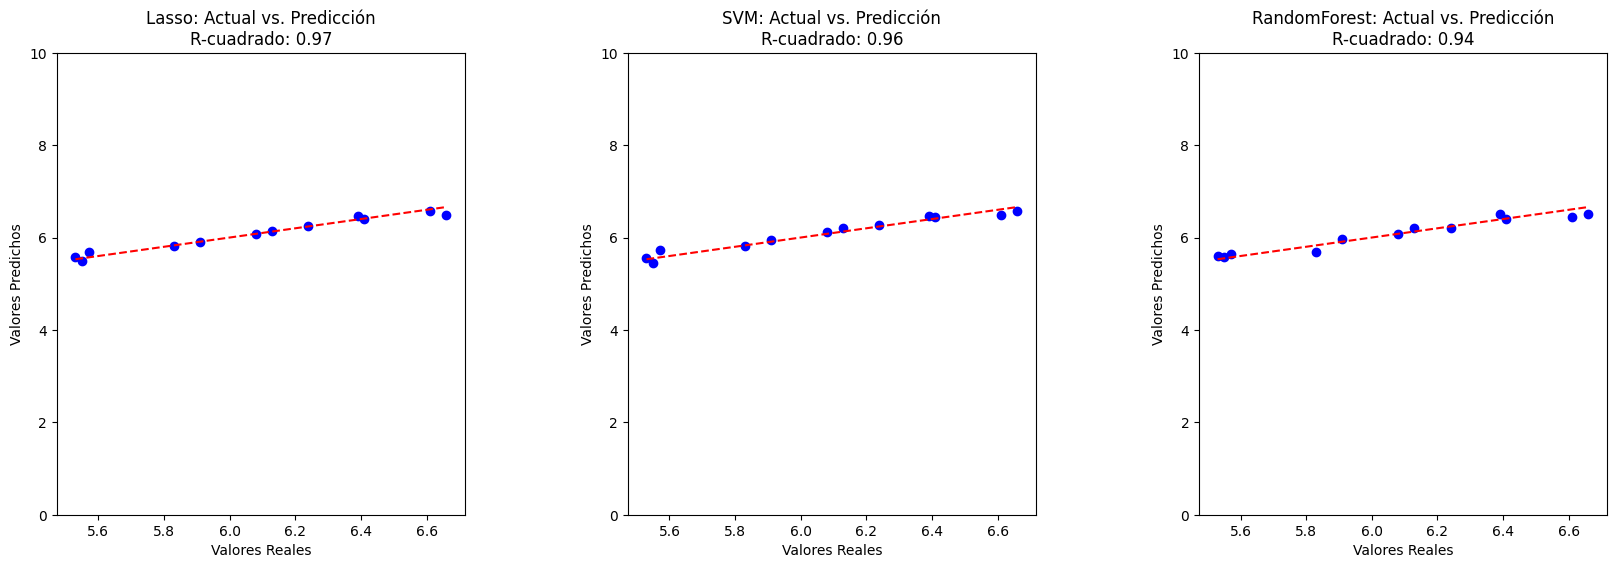

In [ ]:
import matplotlib.pyplot as plt

# Función modificada para generar gráficos en matriz 1x3
def loo_cross_validation_and_plot(models, X, y, title_prefix):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # Crear una figura con una matriz de 1x3 subgráficos
    fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Ajustar el espacio entre los subgráficos

    for i, (name, model) in enumerate(models.items()):
        y_real, y_pred = [], []
        for train_index, test_index in loo.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Entrenar el modelo
            model.fit(X_train, y_train)

            # Realizar predicciones
            predictions = model.predict(X_test)

            # Almacenar valores reales y predichos
            y_real.extend(y_test)
            y_pred.extend(predictions)

        # Calcular R-cuadrado
        r2 = r2_score(y_real, y_pred)

        # Graficar Actual vs. Predicción en el subgráfico correspondiente
        ax = axes[i]
        ax.scatter(y_real, y_pred, color='blue')
        ax.plot([min(y_real), max(y_real)], [min(y_real), max(y_real)], color='red', linestyle='--')
        ax.set_title(f'{name}: Actual vs. Predicción\nR-cuadrado: {r2:.2f}')
        ax.set_xlabel('Valores Reales')
        ax.set_ylabel('Valores Predichos')
        ax.set_ylim(0, 10)  # Ajustar límite del eje Y basado en el valor máximo

    plt.show()

# Ejecutar la validación cruzada y generar gráficos para cada modelo
loo_cross_validation_and_plot(models, X_selected, y, 'SelectKBest')

###### Random Forest

SelectKBest - Lasso R-cuadrado: 0.97
SelectKBest - SVM R-cuadrado: 0.96
SelectKBest - RandomForest R-cuadrado: 0.94
RandomForest Selection - Lasso R-cuadrado: 0.97
RandomForest Selection - SVM R-cuadrado: 0.93
RandomForest Selection - RandomForest R-cuadrado: 0.91


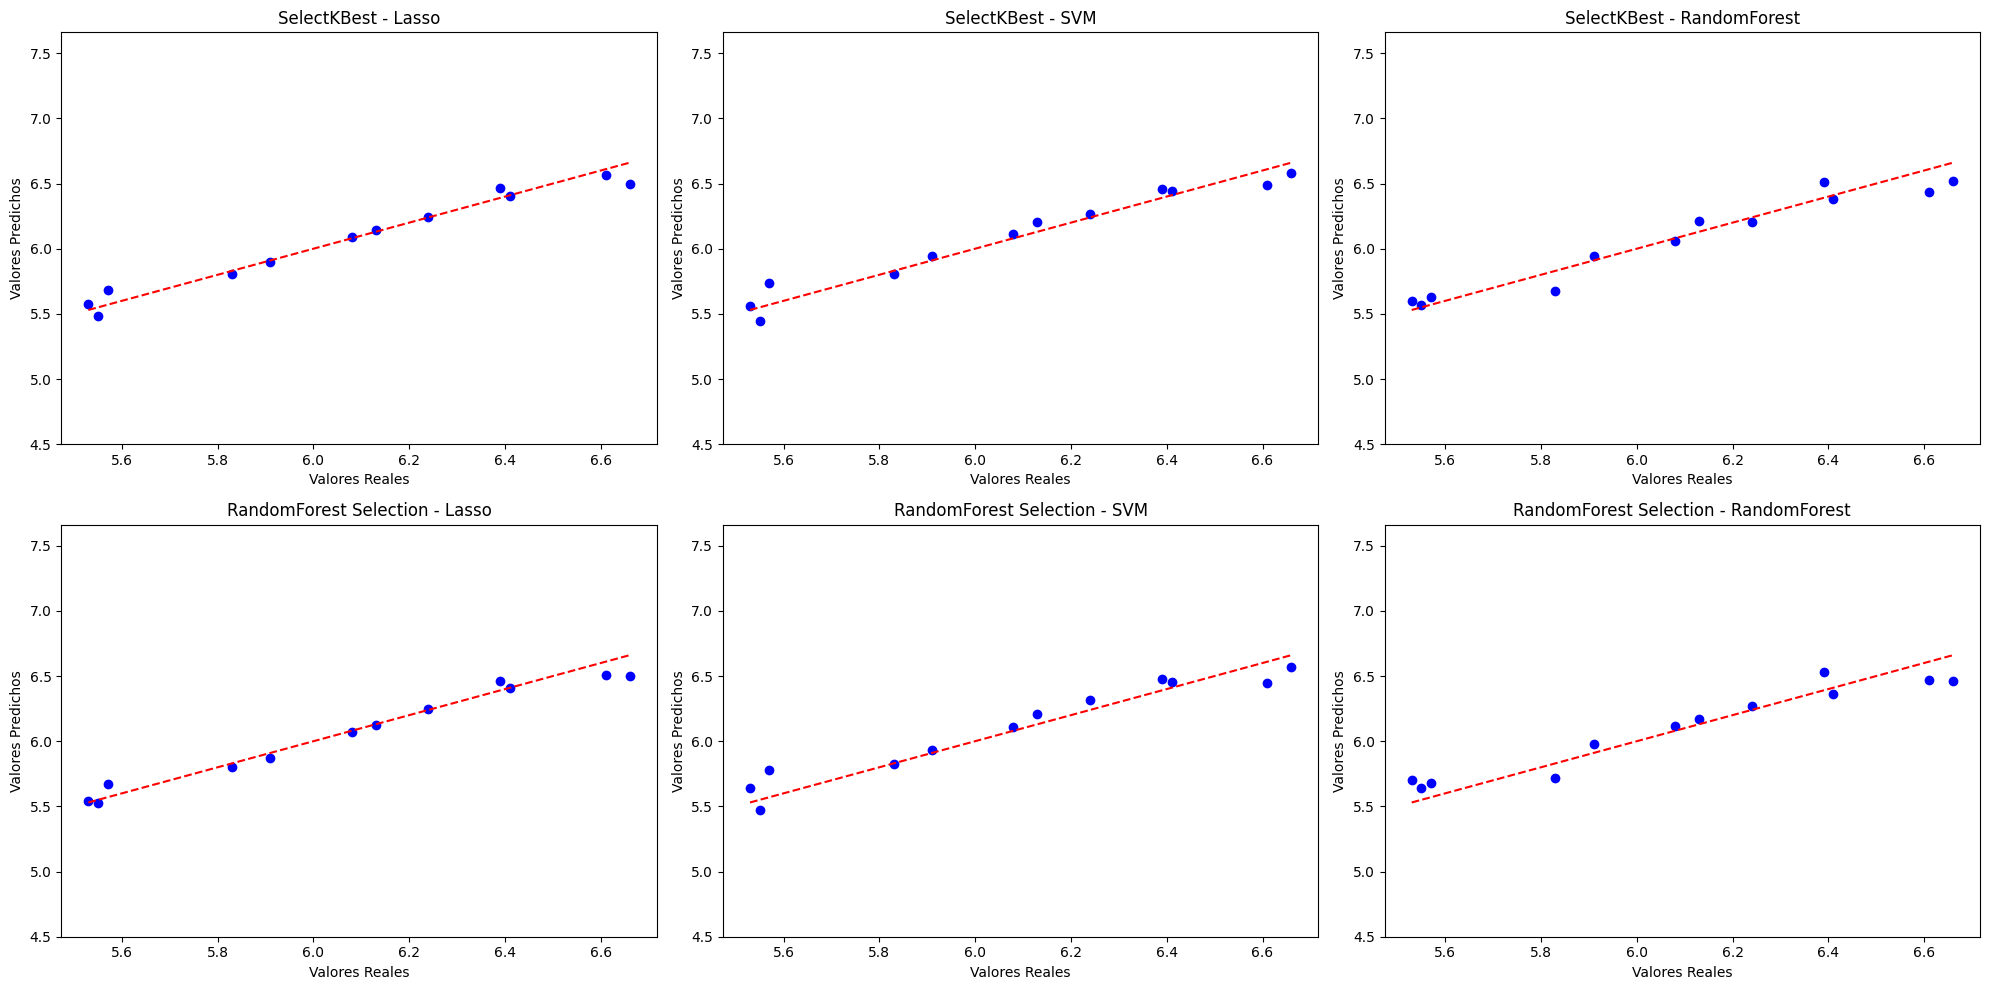

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


# Inicializar LeaveOneOut
loo = LeaveOneOut()

# Inicializar el modelo RandomForest para la selección de características
rf = RandomForestRegressor(n_estimators=100)
rf.fit(df_scaled, y)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Seleccionar las características más importantes según RandomForest
X_rf_selected = df_scaled.iloc[:, indices[:16]]
X_rf = pd.DataFrame(X_rf_selected, columns=df_scaled.columns[indices[:16]])

# Inicializar SelectKBest para la selección de características
selector = SelectKBest(f_regression, k=16)
X_selected = selector.fit_transform(df_scaled, y)
X_kbest = df_scaled[df_scaled.columns[selector.get_support(indices=True)]]

# Inicialización de modelos
models = {
    'Lasso': Lasso(alpha=0.01),
    'SVM': SVR(kernel='linear'),
    'RandomForest': RandomForestRegressor(n_estimators=100)
}

# Función para realizar validación cruzada Leave-One-Out y generar gráficos
def loo_cross_validation_and_plot(models, X, y, title_prefix, axs, row):
    for idx, (name, model) in enumerate(models.items()):
        y_real, y_pred = [], []
        for train_index, test_index in loo.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Entrenar el modelo
            model.fit(X_train, y_train)

            # Realizar predicciones
            predictions = model.predict(X_test)

            # Almacenar valores reales y predichos
            y_real.extend(y_test)
            y_pred.extend(predictions)

        # Graficar Actual vs. Predicción
        axs[row, idx].scatter(y_real, y_pred, color='blue')
        axs[row, idx].plot([min(y_real), max(y_real)], [min(y_real), max(y_real)], color='red', linestyle='--')
        axs[row, idx].set_title(f'{title_prefix} - {name}')
        axs[row, idx].set_xlabel('Valores Reales')
        axs[row, idx].set_ylabel('Valores Predichos')
        axs[row, idx].set_ylim(4.5, max(y) + 1)  # Ajusta el eje Y para mostrar desde 0

        # Calcular y mostrar R-cuadrado
        r2 = r2_score(y_real, y_pred)
        print(f'{title_prefix} - {name} R-cuadrado: {r2:.2f}')

# Preparamos un espacio para graficar con subplots
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

# Ejecutar la validación cruzada y generar gráficos para la selección de características de SelectKBest
loo_cross_validation_and_plot(models, X_kbest, y, 'SelectKBest', axs, row=0)

# Ejecutar la validación cruzada y generar gráficos para la selección de características de RandomForest
loo_cross_validation_and_plot(models, X_rf, y, 'RandomForest Selection', axs, row=1)

# Ajustar layout y mostrar la matriz de gráficos
plt.tight_layout()
plt.show()


##### Cox

###### Cox Unido

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from lifelines import CoxPHFitter
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression

In [ ]:
# Asumiendo que df_scaled y y ya están definidos en tu entorno
event = np.array([1] * 12)  # Asegúrate de que esto coincide con el tamaño de df_scaled después de cualquier filtrado
y_reset = y.reset_index(drop=True)

In [ ]:
# Número de características a seleccionar
k = 16

# Seleccionar características con RandomForest
rf = RandomForestRegressor(n_estimators=100)
rf.fit(df_scaled, y)
feature_importances_rf = pd.Series(rf.feature_importances_, index=df_scaled.columns)
top_features_rf = feature_importances_rf.nlargest(k).index

# Seleccionar características con SelectKBest
selector = SelectKBest(f_regression, k=k)
selector.fit(df_scaled, y)
mask_kbest = selector.get_support()
top_features_kbest = df_scaled.columns[mask_kbest]

# Combinar características seleccionadas sin duplicados
combined_features = pd.Index(top_features_rf).union(pd.Index(top_features_kbest)).drop_duplicates()

# Crear DataFrame con características combinadas
df_selected_features_combined = df_scaled[combined_features]

In [ ]:
# Preparación de los datos para Cox con características seleccionadas por RandomForest
cox_dat = df_selected_features_combined.copy()
cox_dat['duration'] = y_reset
cox_dat['event'] = event

In [ ]:
# Ajustar el modelo de Cox para cada conjunto de características
cph_un = CoxPHFitter(penalizer=0.1)
cph_un.fit(cox_dat, duration_col='duration', event_col='event')

# Resúmenes de los modelos
summary_un = cph_un.summary

In [ ]:
# Convertir los resúmenes a DataFrames
df_summary_un = pd.DataFrame(cph_un.summary)
df_summary_un['c_index'] = cph_un.concordance_index_
df_summary_un

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p),c_index
covariate,,,,,,,,,,,,
Color TV - 0 (%),0.058197,1.059924,0.813684,-1.536594,1.652989,0.215112,5.222565,0.0,0.071523,0.942981,0.084699,0.969697
Color TV - Amount of household appliances,-0.252062,0.777197,0.839245,-1.896951,1.392828,0.150025,4.026222,0.0,-0.300343,0.763915,0.388515,0.969697
Color TV - Average mass of household appliances (kg),0.292973,1.340407,0.851809,-1.376543,1.962489,0.252450,7.117019,0.0,0.343942,0.730890,0.452274,0.969697
Color TV - Imports (kg),-0.063285,0.938676,0.781713,-1.595415,1.468845,0.202824,4.344214,0.0,-0.080957,0.935476,0.096227,0.969697
Color TV - Mass of appliances per household (kg),0.606693,1.834354,0.764209,-0.891129,2.104515,0.410192,8.203120,0.0,0.793883,0.427264,1.226802,0.969697
Color TV - Total Stock of household appliances (Units),-0.286266,0.751063,0.852222,-1.956591,1.384058,0.141339,3.991065,0.0,-0.335906,0.736942,0.440377,0.969697
"Color TV - mmass, kg",-0.080493,0.922662,0.777503,-1.604370,1.443385,0.201016,4.235006,0.0,-0.103527,0.917545,0.124150,0.969697
GASHOG1D,-0.330752,0.718384,0.852467,-2.001557,1.340054,0.135125,3.819249,0.0,-0.387993,0.698021,0.518658,0.969697
GASHOG2D,-0.345980,0.707527,0.853081,-2.017987,1.326027,0.132923,3.766052,0.0,-0.405565,0.685062,0.545694,0.969697


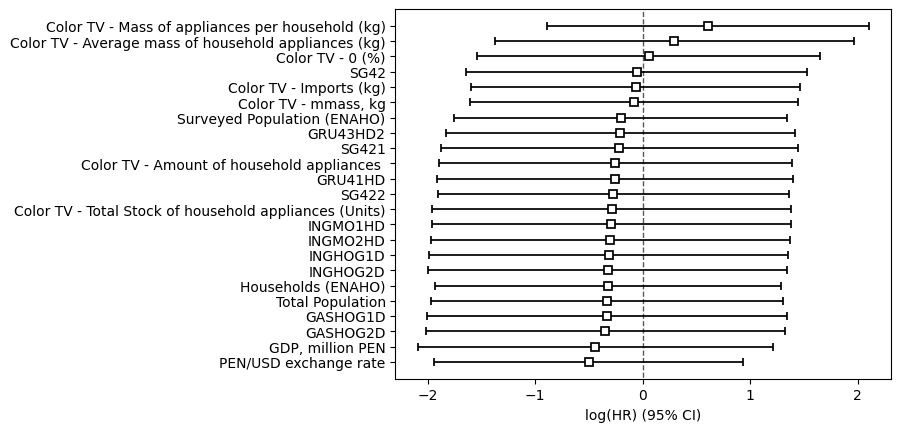

Índice de Concordancia: 0.9697


In [ ]:
# Generar un gráfico forestal para los HR y sus intervalos de confianza
cph_un.plot()
plt.show()

# Calcular y mostrar el índice de concordancia
c_index = cph_un.concordance_index_
print(f"Índice de Concordancia: {c_index:.4f}")

###### Cox Separado

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from lifelines import CoxPHFitter
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression

In [ ]:
# Asumiendo que df_scaled y y ya están definidos en tu entorno
event = np.array([1] * 12)  # Asegúrate de que esto coincide con el tamaño de df_scaled después de cualquier filtrado
y_reset = y.reset_index(drop=True)

In [ ]:
# Entrenar y seleccionar características con RandomForest
rf = RandomForestRegressor(n_estimators=100)
rf.fit(df_scaled, y)
indices_rf = np.argsort(rf.feature_importances_)[-16:]
df_selected_features_rf = df_scaled.iloc[:, indices_rf]

In [ ]:
# Seleccionar características con SelectKBest
selector = SelectKBest(f_regression, k=16)
X_selected = selector.fit_transform(df_scaled, y)
indices_kbest = np.where(selector.get_support())[0]
df_selected_features_kbest = df_scaled.iloc[:, indices_kbest]

In [ ]:
# Preparación de los datos para Cox con características seleccionadas por RandomForest
cox_data_rf = df_selected_features_rf.copy()
cox_data_rf['duration'] = y_reset
cox_data_rf['event'] = event

In [ ]:
# Preparación de los datos para Cox con características seleccionadas por SelectKBest
cox_data_kbest = df_selected_features_kbest.copy()
cox_data_kbest['duration'] = y_reset
cox_data_kbest['event'] = event

In [ ]:
# Ajustar el modelo de Cox para cada conjunto de características
cph_rf = CoxPHFitter(penalizer=0.1)
cph_rf.fit(cox_data_rf, duration_col='duration', event_col='event')

# Refit the Cox model for SelectKBest selected features
cph_kbest = CoxPHFitter(penalizer=0.1)
cph_kbest.fit(cox_data_kbest, duration_col='duration', event_col='event')


# Resúmenes de los modelos
summary_rf = cph_rf.summary
summary_kbest = cph_kbest.summary

In [ ]:
# Convertir los resúmenes a DataFrames
df_summary_rf = pd.DataFrame(cph_rf.summary)
df_summary_rf['c_index'] = cph_rf.concordance_index_
df_summary_rf

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p),c_index
covariate,,,,,,,,,,,,
Color TV - Imports (kg),0.058459,1.060201,0.774728,-1.459981,1.576898,0.232241,4.839921,0.0,0.075457,0.939851,0.089496,0.984848
SG421,-0.437849,0.645423,0.834142,-2.072738,1.197039,0.125841,3.310302,0.0,-0.524910,0.599646,0.737817,0.984848
GASHOG2D,-0.540084,0.582699,0.839561,-2.185593,1.105425,0.112411,3.020508,0.0,-0.643293,0.520034,0.943323,0.984848
Color TV - Mass of appliances per household (kg),0.668319,1.950955,0.744737,-0.791340,2.127977,0.453237,8.397864,0.0,0.897388,0.369512,1.436308,0.984848
Total Population,-0.558086,0.572303,0.821060,-2.167334,1.051162,0.114482,2.860974,0.0,-0.679714,0.496686,1.009595,0.984848
SG42D1,-0.261348,0.770013,0.820959,-1.870398,1.347702,0.154062,3.848571,0.0,-0.318345,0.750223,0.414608,0.984848
INGMO1HD,-0.502857,0.604800,0.838674,-2.146628,1.140914,0.116878,3.129628,0.0,-0.599586,0.548782,0.865694,0.984848
GRU41HD,-0.486639,0.614689,0.836842,-2.126818,1.153541,0.119216,3.169394,0.0,-0.581519,0.560891,0.834208,0.984848
Households (ENAHO),-0.402064,0.668938,0.794470,-1.959195,1.155068,0.140972,3.174240,0.0,-0.506078,0.612802,0.706507,0.984848


In [ ]:
# Convertir los resúmenes a DataFrames
df_summary_sk = pd.DataFrame(cph_kbest.summary)
df_summary_sk['c_index'] = cph_kbest.concordance_index_
df_summary_sk

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p),c_index
covariate,,,,,,,,,,,,
Total Population,-0.431973,0.649227,0.823905,-2.046797,1.182851,0.129148,3.263667,0.0,-0.524299,0.600070,0.736796,0.969697
Households (ENAHO),-0.473235,0.622983,0.792549,-2.026602,1.080131,0.131783,2.945066,0.0,-0.597106,0.550437,0.861351,0.969697
"GDP, million PEN",-0.525835,0.591062,0.836184,-2.164726,1.113056,0.114781,3.043645,0.0,-0.628851,0.529447,0.917443,0.969697
Color TV - Amount of household appliances,-0.283731,0.752969,0.817443,-1.885890,1.318428,0.151694,3.737543,0.0,-0.347096,0.728519,0.456961,0.969697
Color TV - Total Stock of household appliances (Units),-0.263076,0.768684,0.846493,-1.922172,1.396020,0.146289,4.039094,0.0,-0.310783,0.755966,0.403608,0.969697
Color TV - Average mass of household appliances (kg),0.371378,1.449731,0.845130,-1.285047,2.027803,0.276637,7.597376,0.0,0.439432,0.660348,0.598701,0.969697
GASHOG1D,-0.334303,0.715837,0.849464,-1.999222,1.330616,0.135441,3.783373,0.0,-0.393546,0.693916,0.527167,0.969697
GASHOG2D,-0.375688,0.686817,0.850701,-2.043030,1.291655,0.129635,3.638803,0.0,-0.441622,0.658763,0.602169,0.969697
GRU41HD,-0.259516,0.771425,0.835183,-1.896443,1.377412,0.150102,3.964629,0.0,-0.310729,0.756007,0.403529,0.969697


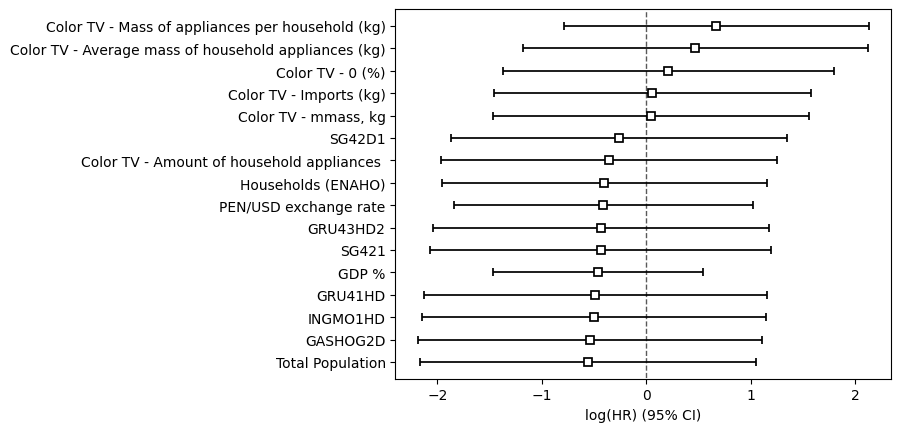

Índice de Concordancia: 0.9848


In [ ]:
# Generar un gráfico forestal para los HR y sus intervalos de confianza
cph_rf.plot()
plt.show()

# Calcular y mostrar el índice de concordancia
c_index = cph_rf.concordance_index_
print(f"Índice de Concordancia: {c_index:.4f}")

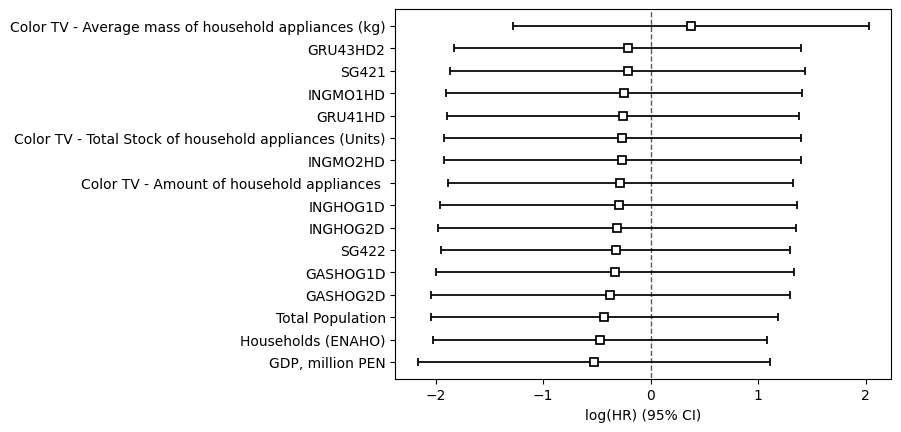

Índice de Concordancia: 0.9697


In [ ]:
# Generar un gráfico forestal para los HR y sus intervalos de confianza
cph_kbest.plot()
plt.show()

# Calcular y mostrar el índice de concordancia
c_index = cph_kbest.concordance_index_
print(f"Índice de Concordancia: {c_index:.4f}")

###### Grafico

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd


# Entrenar un modelo RandomForest
rf = RandomForestRegressor(n_estimators=100)  # Puedes ajustar el número de estimadores
rf.fit(df_scaled, y)

# Obtener la importancia de las características
feature_importances = rf.feature_importances_

# Crear un DataFrame para visualizar la importancia de las características
feature_importances_df = pd.DataFrame({
    'Feature': df_scaled.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Seleccionar las características más importantes
# Por ejemplo, seleccionar las 10 características más importantes
top_features = feature_importances_df.head(16)['Feature']

# Crear un nuevo DataFrame con solo las características seleccionadas
df_selected_features = df_scaled[top_features]

# Ahora df_selected_features está listo para ser utilizado en tu análisis posterior
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd

# Asume que ya tienes df_scaled, y y event preparados
# df_scaled = ... (tu DataFrame normalizado)
# y = df_temporalmente_excluidas['Vida Útil Promedio'].astype('float64')
# event = df_temporalmente_excluidas['event']  # Columna que indica si ocurrió el evento

# Preparar los datos para el modelo de Cox
cox_data = df_selected_features.copy()
cox_data['duration'] = df_temporalmente_excluidas['Vida Útil Promedio'].astype('float64').reset_index(drop=True)
cox_data['event'] = 1  # Aquí se asume que todos los eventos son '1'

# Ajustar el modelo de Cox con penalización para ayudar con la colinealidad
cph = CoxPHFitter(penalizer=0.1)
cph.fit(cox_data, duration_col='duration', event_col='event')

# Mostrar el resumen del modelo
summary = cph.summary
print(summary)

# Generar un gráfico forestal para los HR y sus intervalos de confianza
cph.plot()
plt.show()

# Calcular y mostrar el índice de concordancia
c_index = cph.concordance_index_
print(f"Índice de Concordancia: {c_index:.4f}")
